In [1]:
import sys
sys.path.append("../../")

import bayesflow as bf
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from bayesflow.experimental.rectifiers import RectifiedDistribution
from summary import CustomSummary
from evaluation import eval_performance
from amortizers import ConsistencyAmortizer, ConfigurableMLP, DriftNetwork

2023-12-06 19:38:10.605265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 19:38:10.635097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 19:38:11.018002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonot

## Data Loading and Configuration

In [2]:
def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
    assert(len(obs_path) == len(param_path))
    observables = []
    params = []
    for i in range(len(obs_path)):
        observables.append(pd.read_pickle(obs_path[i]))
        params.append(pd.read_pickle(param_path[i]))
    obs = np.stack(pd.concat(observables).to_numpy())
    tumor_size = np.stack(obs[:,0])[:, :, None].astype(np.float32)
    radial_features = np.stack([np.stack(obs[:,1]),np.stack(obs[:,2])], axis=-1)[:,:300,:].astype(np.float32)
    params = pd.concat(params).to_numpy().astype(np.float32)
    split = int(validation_ratio * params.shape[0])
    train = {"prior_draws": params[split:], 
             "sim_data": radial_features[split:], 
             'growth_curve': tumor_size[split:]}
    validation = {"prior_draws": params[:split], 
                  "sim_data": radial_features[:split], 
                  'growth_curve': tumor_size[:split]}    
    return train, validation

In [3]:
def configure_input(forward_dict):
    """Custom configurator."""
    
    out_dict = {}
    pp_ecmp = (forward_dict['sim_data'] - MEAN_SIM) / STD_SIM
    pp_ecmp = np.c_[pp_ecmp, [POSITIONAL_EMBEDDINGS]*pp_ecmp.shape[0]]
    growth =  (forward_dict['growth_curve'] - MEAN_GROWTH) / STD_GROWTH 
    params = forward_dict['prior_draws']
    
    out_dict = {
        'summary_conditions': (pp_ecmp, growth),
        'parameters': params
    }    
    return out_dict

In [4]:
train_data, val_data = read_offline_data(
    obs_path=['../../tumor_data/observables_10000_1.pkl', '../../tumor_data/observables_10000_2.pkl'],
    param_path=['../../tumor_data/params_10000_1.pkl', '../../tumor_data/params_10000_2.pkl']
)

In [5]:
MEAN_GROWTH = train_data['growth_curve'].mean((0, 1))
STD_GROWTH = train_data['growth_curve'].std((0, 1))
MEAN_SIM = train_data['sim_data'].mean((0, 1))
STD_SIM = train_data['sim_data'].std((0, 1))
MEAN_PARAMS = train_data['prior_draws'].mean((0, 1))
STD_PARAMS = train_data['prior_draws'].mean((0, 1))

## Networks

In [7]:
BATCH_SIZE = 64
EPOCHS = 2000
POSITIONAL_EMBEDDINGS = np.linspace(0, 1, train_data['sim_data'].shape[1], dtype=np.float32)[:, None]

In [8]:
ITERATIONS = int(np.ceil((train_data['sim_data'].shape[0] / BATCH_SIZE))*EPOCHS)

In [10]:
summary_net = CustomSummary()

inference_net = ConfigurableMLP(
    input_dim=train_data['prior_draws'].shape[-1],
    condition_dim=32,
    hidden_dim=512,
    num_hidden=4,
    dropout_rate=0.2,
)

amortizer = ConsistencyAmortizer(
    consistency_net=inference_net, 
    num_steps=ITERATIONS, 
    summary_net=summary_net,
    sigma2=tf.math.reduce_variance(train_data['prior_draws'], axis=0, keepdims=True),
    T_max=100
)

## Consistency Trainer

In [11]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=configure_input,
    checkpoint_path='ckpt/cm2k',
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


In [12]:
h = trainer.train_offline(
    train_data, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_sims=val_data
)

Training epoch 1:   0%|          | 0/307 [00:00<?, ?it/s]

2023-12-06 19:38:33.660783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-06 19:38:33.679681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-06 19:38:33.829013: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc118a98250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 19:38:33.829029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2023-12-06 19:38:33.831732: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 19:38:33.897831: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

Training epoch 2:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.528


Training epoch 3:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.495


Training epoch 4:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.472


Training epoch 5:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.463


Training epoch 6:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.461


Training epoch 7:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.470


Training epoch 8:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.455


Training epoch 9:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.476


Training epoch 10:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 0.482


Training epoch 11:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 0.439


Training epoch 12:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.423


Training epoch 13:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.440


Training epoch 14:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 0.473


Training epoch 15:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 0.451


Training epoch 16:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.443


Training epoch 17:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.411


Training epoch 18:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.438


Training epoch 19:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 0.455


Training epoch 20:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.409


Training epoch 21:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.427


Training epoch 22:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.465


Training epoch 23:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.440


Training epoch 24:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.420


Training epoch 25:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.440


Training epoch 26:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.410


Training epoch 27:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.411


Training epoch 28:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.422


Training epoch 29:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 0.411


Training epoch 30:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.436


Training epoch 31:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.465


Training epoch 32:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.424


Training epoch 33:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.430


Training epoch 34:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.420


Training epoch 35:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 0.450


Training epoch 36:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.417


Training epoch 37:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.434


Training epoch 38:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.421


Training epoch 39:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.442


Training epoch 40:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.407


Training epoch 41:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.420


Training epoch 42:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 0.439


Training epoch 43:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 0.430


Training epoch 44:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.402


Training epoch 45:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 0.429


Training epoch 46:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 0.413


Training epoch 47:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.425


Training epoch 48:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.419


Training epoch 49:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.392


Training epoch 50:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 0.438


Training epoch 51:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.451


Training epoch 52:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 0.431


Training epoch 53:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.436


Training epoch 54:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.402


Training epoch 55:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.418


Training epoch 56:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.392


Training epoch 57:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.406


Training epoch 58:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.412


Training epoch 59:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.415


Training epoch 60:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.425


Training epoch 61:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.399


Training epoch 62:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.422


Training epoch 63:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.409


Training epoch 64:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.392


Training epoch 65:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.397


Training epoch 66:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.411


Training epoch 67:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.404


Training epoch 68:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.416


Training epoch 69:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.415


Training epoch 70:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.440


Training epoch 71:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.390


Training epoch 72:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.401


Training epoch 73:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.420


Training epoch 74:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.403


Training epoch 75:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.442


Training epoch 76:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.405


Training epoch 77:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.407


Training epoch 78:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.394


Training epoch 79:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.405


Training epoch 80:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.400


Training epoch 81:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.423


Training epoch 82:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.380


Training epoch 83:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.407


Training epoch 84:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.376


Training epoch 85:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.417


Training epoch 86:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.403


Training epoch 87:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.406


Training epoch 88:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.420


Training epoch 89:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.409


Training epoch 90:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.384


Training epoch 91:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.389


Training epoch 92:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.401


Training epoch 93:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.366


Training epoch 94:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.398


Training epoch 95:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.411


Training epoch 96:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.403


Training epoch 97:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.395


Training epoch 98:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.377


Training epoch 99:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.419


Training epoch 100:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.416


Training epoch 101:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: 0.404


Training epoch 102:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: 0.403


Training epoch 103:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: 0.391


Training epoch 104:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: 0.399


Training epoch 105:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: 0.399


Training epoch 106:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: 0.413


Training epoch 107:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: 0.387


Training epoch 108:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: 0.393


Training epoch 109:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: 0.441


Training epoch 110:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: 0.416


Training epoch 111:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: 0.401


Training epoch 112:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: 0.437


Training epoch 113:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: 0.411


Training epoch 114:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: 0.393


Training epoch 115:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: 0.395


Training epoch 116:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: 0.380


Training epoch 117:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: 0.395


Training epoch 118:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: 0.395


Training epoch 119:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: 0.380


Training epoch 120:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: 0.374


Training epoch 121:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: 0.387


Training epoch 122:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: 0.390


Training epoch 123:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: 0.377


Training epoch 124:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Loss: 0.383


Training epoch 125:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Loss: 0.412


Training epoch 126:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Loss: 0.409


Training epoch 127:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Loss: 0.397


Training epoch 128:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Loss: 0.385


Training epoch 129:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Loss: 0.374


Training epoch 130:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Loss: 0.372


Training epoch 131:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Loss: 0.404


Training epoch 132:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Loss: 0.399


Training epoch 133:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Loss: 0.414


Training epoch 134:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Loss: 0.408


Training epoch 135:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Loss: 0.406


Training epoch 136:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Loss: 0.412


Training epoch 137:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Loss: 0.416


Training epoch 138:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Loss: 0.404


Training epoch 139:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Loss: 0.400


Training epoch 140:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Loss: 0.387


Training epoch 141:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Loss: 0.409


Training epoch 142:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Loss: 0.387


Training epoch 143:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Loss: 0.394


Training epoch 144:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Loss: 0.393


Training epoch 145:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Loss: 0.410


Training epoch 146:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Loss: 0.393


Training epoch 147:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Loss: 0.410


Training epoch 148:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Loss: 0.367


Training epoch 149:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Loss: 0.409


Training epoch 150:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Loss: 0.400


Training epoch 151:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 151, Loss: 0.380


Training epoch 152:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 152, Loss: 0.414


Training epoch 153:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 153, Loss: 0.393


Training epoch 154:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 154, Loss: 0.396


Training epoch 155:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 155, Loss: 0.397


Training epoch 156:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 156, Loss: 0.401


Training epoch 157:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 157, Loss: 0.383


Training epoch 158:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 158, Loss: 0.387


Training epoch 159:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 159, Loss: 0.376


Training epoch 160:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 160, Loss: 0.393


Training epoch 161:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 161, Loss: 0.361


Training epoch 162:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 162, Loss: 0.399


Training epoch 163:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 163, Loss: 0.382


Training epoch 164:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 164, Loss: 0.377


Training epoch 165:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 165, Loss: 0.385


Training epoch 166:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 166, Loss: 0.400


Training epoch 167:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 167, Loss: 0.388


Training epoch 168:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 168, Loss: 0.404


Training epoch 169:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 169, Loss: 0.399


Training epoch 170:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 170, Loss: 0.395


Training epoch 171:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 171, Loss: 0.400


Training epoch 172:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 172, Loss: 0.380


Training epoch 173:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 173, Loss: 0.390


Training epoch 174:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 174, Loss: 0.411


Training epoch 175:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 175, Loss: 0.379


Training epoch 176:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 176, Loss: 0.384


Training epoch 177:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 177, Loss: 0.383


Training epoch 178:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 178, Loss: 0.393


Training epoch 179:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 179, Loss: 0.386


Training epoch 180:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 180, Loss: 0.397


Training epoch 181:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 181, Loss: 0.402


Training epoch 182:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 182, Loss: 0.388


Training epoch 183:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 183, Loss: 0.390


Training epoch 184:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 184, Loss: 0.381


Training epoch 185:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 185, Loss: 0.397


Training epoch 186:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 186, Loss: 0.412


Training epoch 187:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 187, Loss: 0.422


Training epoch 188:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 188, Loss: 0.396


Training epoch 189:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 189, Loss: 0.382


Training epoch 190:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 190, Loss: 0.408


Training epoch 191:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 191, Loss: 0.389


Training epoch 192:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 192, Loss: 0.398


Training epoch 193:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 193, Loss: 0.404


Training epoch 194:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 194, Loss: 0.369


Training epoch 195:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 195, Loss: 0.396


Training epoch 196:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 196, Loss: 0.418


Training epoch 197:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 197, Loss: 0.391


Training epoch 198:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 198, Loss: 0.387


Training epoch 199:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 199, Loss: 0.389


Training epoch 200:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 200, Loss: 0.358


Training epoch 201:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 201, Loss: 0.384


Training epoch 202:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 202, Loss: 0.408


Training epoch 203:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 203, Loss: 0.428


Training epoch 204:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 204, Loss: 0.396


Training epoch 205:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 205, Loss: 0.414


Training epoch 206:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 206, Loss: 0.392


Training epoch 207:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 207, Loss: 0.398


Training epoch 208:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 208, Loss: 0.343


Training epoch 209:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 209, Loss: 0.405


Training epoch 210:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 210, Loss: 0.397


Training epoch 211:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 211, Loss: 0.423


Training epoch 212:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 212, Loss: 0.373


Training epoch 213:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 213, Loss: 0.376


Training epoch 214:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 214, Loss: 0.393


Training epoch 215:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 215, Loss: 0.396


Training epoch 216:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 216, Loss: 0.402


Training epoch 217:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 217, Loss: 0.402


Training epoch 218:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 218, Loss: 0.394


Training epoch 219:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 219, Loss: 0.392


Training epoch 220:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 220, Loss: 0.384


Training epoch 221:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 221, Loss: 0.389


Training epoch 222:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 222, Loss: 0.381


Training epoch 223:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 223, Loss: 0.382


Training epoch 224:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 224, Loss: 0.397


Training epoch 225:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 225, Loss: 0.408


Training epoch 226:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 226, Loss: 0.399


Training epoch 227:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 227, Loss: 0.395


Training epoch 228:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 228, Loss: 0.385


Training epoch 229:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 229, Loss: 0.374


Training epoch 230:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 230, Loss: 0.387


Training epoch 231:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 231, Loss: 0.383


Training epoch 232:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 232, Loss: 0.385


Training epoch 233:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 233, Loss: 0.395


Training epoch 234:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 234, Loss: 0.410


Training epoch 235:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 235, Loss: 0.398


Training epoch 236:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 236, Loss: 0.404


Training epoch 237:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 237, Loss: 0.374


Training epoch 238:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 238, Loss: 0.415


Training epoch 239:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 239, Loss: 0.393


Training epoch 240:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 240, Loss: 0.398


Training epoch 241:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 241, Loss: 0.378


Training epoch 242:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 242, Loss: 0.361


Training epoch 243:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 243, Loss: 0.390


Training epoch 244:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 244, Loss: 0.396


Training epoch 245:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 245, Loss: 0.369


Training epoch 246:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 246, Loss: 0.410


Training epoch 247:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 247, Loss: 0.394


Training epoch 248:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 248, Loss: 0.398


Training epoch 249:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 249, Loss: 0.386


Training epoch 250:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 250, Loss: 0.387


Training epoch 251:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 251, Loss: 0.395


Training epoch 252:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 252, Loss: 0.376


Training epoch 253:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 253, Loss: 0.399


Training epoch 254:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 254, Loss: 0.399


Training epoch 255:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 255, Loss: 0.364


Training epoch 256:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 256, Loss: 0.372


Training epoch 257:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 257, Loss: 0.371


Training epoch 258:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 258, Loss: 0.375


Training epoch 259:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 259, Loss: 0.409


Training epoch 260:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 260, Loss: 0.404


Training epoch 261:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 261, Loss: 0.384


Training epoch 262:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 262, Loss: 0.403


Training epoch 263:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 263, Loss: 0.375


Training epoch 264:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 264, Loss: 0.390


Training epoch 265:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 265, Loss: 0.390


Training epoch 266:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 266, Loss: 0.386


Training epoch 267:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 267, Loss: 0.383


Training epoch 268:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 268, Loss: 0.381


Training epoch 269:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 269, Loss: 0.395


Training epoch 270:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 270, Loss: 0.398


Training epoch 271:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 271, Loss: 0.389


Training epoch 272:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 272, Loss: 0.414


Training epoch 273:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 273, Loss: 0.422


Training epoch 274:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 274, Loss: 0.374


Training epoch 275:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 275, Loss: 0.396


Training epoch 276:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 276, Loss: 0.392


Training epoch 277:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 277, Loss: 0.410


Training epoch 278:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 278, Loss: 0.390


Training epoch 279:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 279, Loss: 0.375


Training epoch 280:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 280, Loss: 0.398


Training epoch 281:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 281, Loss: 0.388


Training epoch 282:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 282, Loss: 0.414


Training epoch 283:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 283, Loss: 0.375


Training epoch 284:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 284, Loss: 0.374


Training epoch 285:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 285, Loss: 0.395


Training epoch 286:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 286, Loss: 0.384


Training epoch 287:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 287, Loss: 0.358


Training epoch 288:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 288, Loss: 0.380


Training epoch 289:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 289, Loss: 0.358


Training epoch 290:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 290, Loss: 0.396


Training epoch 291:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 291, Loss: 0.400


Training epoch 292:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 292, Loss: 0.398


Training epoch 293:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 293, Loss: 0.371


Training epoch 294:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 294, Loss: 0.403


Training epoch 295:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 295, Loss: 0.408


Training epoch 296:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 296, Loss: 0.381


Training epoch 297:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 297, Loss: 0.376


Training epoch 298:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 298, Loss: 0.398


Training epoch 299:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 299, Loss: 0.381


Training epoch 300:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 300, Loss: 0.389


Training epoch 301:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 301, Loss: 0.411


Training epoch 302:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 302, Loss: 0.389


Training epoch 303:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 303, Loss: 0.389


Training epoch 304:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 304, Loss: 0.387


Training epoch 305:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 305, Loss: 0.378


Training epoch 306:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 306, Loss: 0.381


Training epoch 307:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 307, Loss: 0.382


Training epoch 308:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 308, Loss: 0.401


Training epoch 309:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 309, Loss: 0.367


Training epoch 310:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 310, Loss: 0.401


Training epoch 311:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 311, Loss: 0.398


Training epoch 312:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 312, Loss: 0.386


Training epoch 313:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 313, Loss: 0.382


Training epoch 314:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 314, Loss: 0.388


Training epoch 315:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 315, Loss: 0.411


Training epoch 316:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 316, Loss: 0.392


Training epoch 317:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 317, Loss: 0.380


Training epoch 318:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 318, Loss: 0.386


Training epoch 319:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 319, Loss: 0.406


Training epoch 320:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 320, Loss: 0.408


Training epoch 321:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 321, Loss: 0.364


Training epoch 322:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 322, Loss: 0.375


Training epoch 323:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 323, Loss: 0.417


Training epoch 324:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 324, Loss: 0.393


Training epoch 325:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 325, Loss: 0.382


Training epoch 326:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 326, Loss: 0.373


Training epoch 327:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 327, Loss: 0.379


Training epoch 328:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 328, Loss: 0.370


Training epoch 329:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 329, Loss: 0.389


Training epoch 330:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 330, Loss: 0.393


Training epoch 331:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 331, Loss: 0.391


Training epoch 332:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 332, Loss: 0.372


Training epoch 333:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 333, Loss: 0.387


Training epoch 334:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 334, Loss: 0.404


Training epoch 335:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 335, Loss: 0.369


Training epoch 336:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 336, Loss: 0.421


Training epoch 337:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 337, Loss: 0.381


Training epoch 338:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 338, Loss: 0.402


Training epoch 339:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 339, Loss: 0.376


Training epoch 340:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 340, Loss: 0.393


Training epoch 341:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 341, Loss: 0.368


Training epoch 342:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 342, Loss: 0.375


Training epoch 343:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 343, Loss: 0.373


Training epoch 344:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 344, Loss: 0.387


Training epoch 345:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 345, Loss: 0.408


Training epoch 346:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 346, Loss: 0.376


Training epoch 347:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 347, Loss: 0.376


Training epoch 348:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 348, Loss: 0.377


Training epoch 349:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 349, Loss: 0.384


Training epoch 350:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 350, Loss: 0.402


Training epoch 351:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 351, Loss: 0.382


Training epoch 352:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 352, Loss: 0.395


Training epoch 353:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 353, Loss: 0.378


Training epoch 354:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 354, Loss: 0.380


Training epoch 355:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 355, Loss: 0.376


Training epoch 356:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 356, Loss: 0.360


Training epoch 357:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 357, Loss: 0.389


Training epoch 358:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 358, Loss: 0.375


Training epoch 359:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 359, Loss: 0.388


Training epoch 360:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 360, Loss: 0.404


Training epoch 361:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 361, Loss: 0.384


Training epoch 362:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 362, Loss: 0.390


Training epoch 363:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 363, Loss: 0.382


Training epoch 364:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 364, Loss: 0.388


Training epoch 365:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 365, Loss: 0.367


Training epoch 366:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 366, Loss: 0.384


Training epoch 367:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 367, Loss: 0.383


Training epoch 368:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 368, Loss: 0.376


Training epoch 369:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 369, Loss: 0.354


Training epoch 370:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 370, Loss: 0.379


Training epoch 371:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 371, Loss: 0.381


Training epoch 372:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 372, Loss: 0.379


Training epoch 373:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 373, Loss: 0.378


Training epoch 374:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 374, Loss: 0.356


Training epoch 375:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 375, Loss: 0.386


Training epoch 376:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 376, Loss: 0.401


Training epoch 377:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 377, Loss: 0.353


Training epoch 378:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 378, Loss: 0.377


Training epoch 379:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 379, Loss: 0.377


Training epoch 380:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 380, Loss: 0.360


Training epoch 381:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 381, Loss: 0.377


Training epoch 382:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 382, Loss: 0.391


Training epoch 383:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 383, Loss: 0.399


Training epoch 384:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 384, Loss: 0.373


Training epoch 385:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 385, Loss: 0.367


Training epoch 386:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 386, Loss: 0.374


Training epoch 387:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 387, Loss: 0.403


Training epoch 388:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 388, Loss: 0.369


Training epoch 389:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 389, Loss: 0.385


Training epoch 390:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 390, Loss: 0.387


Training epoch 391:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 391, Loss: 0.406


Training epoch 392:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 392, Loss: 0.365


Training epoch 393:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 393, Loss: 0.384


Training epoch 394:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 394, Loss: 0.390


Training epoch 395:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 395, Loss: 0.377


Training epoch 396:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 396, Loss: 0.361


Training epoch 397:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 397, Loss: 0.402


Training epoch 398:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 398, Loss: 0.370


Training epoch 399:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 399, Loss: 0.375


Training epoch 400:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 400, Loss: 0.409


Training epoch 401:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 401, Loss: 0.378


Training epoch 402:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 402, Loss: 0.381


Training epoch 403:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 403, Loss: 0.391


Training epoch 404:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 404, Loss: 0.398


Training epoch 405:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 405, Loss: 0.403


Training epoch 406:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 406, Loss: 0.373


Training epoch 407:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 407, Loss: 0.412


Training epoch 408:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 408, Loss: 0.372


Training epoch 409:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 409, Loss: 0.366


Training epoch 410:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 410, Loss: 0.380


Training epoch 411:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 411, Loss: 0.373


Training epoch 412:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 412, Loss: 0.370


Training epoch 413:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 413, Loss: 0.393


Training epoch 414:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 414, Loss: 0.384


Training epoch 415:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 415, Loss: 0.381


Training epoch 416:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 416, Loss: 0.367


Training epoch 417:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 417, Loss: 0.388


Training epoch 418:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 418, Loss: 0.371


Training epoch 419:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 419, Loss: 0.362


Training epoch 420:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 420, Loss: 0.393


Training epoch 421:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 421, Loss: 0.379


Training epoch 422:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 422, Loss: 0.410


Training epoch 423:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 423, Loss: 0.393


Training epoch 424:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 424, Loss: 0.372


Training epoch 425:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 425, Loss: 0.373


Training epoch 426:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 426, Loss: 0.391


Training epoch 427:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 427, Loss: 0.376


Training epoch 428:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 428, Loss: 0.373


Training epoch 429:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 429, Loss: 0.383


Training epoch 430:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 430, Loss: 0.370


Training epoch 431:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 431, Loss: 0.391


Training epoch 432:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 432, Loss: 0.363


Training epoch 433:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 433, Loss: 0.376


Training epoch 434:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 434, Loss: 0.366


Training epoch 435:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 435, Loss: 0.369


Training epoch 436:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 436, Loss: 0.390


Training epoch 437:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 437, Loss: 0.395


Training epoch 438:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 438, Loss: 0.374


Training epoch 439:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 439, Loss: 0.400


Training epoch 440:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 440, Loss: 0.382


Training epoch 441:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 441, Loss: 0.388


Training epoch 442:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 442, Loss: 0.386


Training epoch 443:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 443, Loss: 0.377


Training epoch 444:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 444, Loss: 0.378


Training epoch 445:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 445, Loss: 0.396


Training epoch 446:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 446, Loss: 0.380


Training epoch 447:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 447, Loss: 0.365


Training epoch 448:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 448, Loss: 0.367


Training epoch 449:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 449, Loss: 0.383


Training epoch 450:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 450, Loss: 0.369


Training epoch 451:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 451, Loss: 0.386


Training epoch 452:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 452, Loss: 0.394


Training epoch 453:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 453, Loss: 0.388


Training epoch 454:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 454, Loss: 0.363


Training epoch 455:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 455, Loss: 0.374


Training epoch 456:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 456, Loss: 0.391


Training epoch 457:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 457, Loss: 0.369


Training epoch 458:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 458, Loss: 0.385


Training epoch 459:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 459, Loss: 0.354


Training epoch 460:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 460, Loss: 0.392


Training epoch 461:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 461, Loss: 0.399


Training epoch 462:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 462, Loss: 0.357


Training epoch 463:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 463, Loss: 0.397


Training epoch 464:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 464, Loss: 0.384


Training epoch 465:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 465, Loss: 0.361


Training epoch 466:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 466, Loss: 0.370


Training epoch 467:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 467, Loss: 0.388


Training epoch 468:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 468, Loss: 0.382


Training epoch 469:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 469, Loss: 0.361


Training epoch 470:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 470, Loss: 0.375


Training epoch 471:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 471, Loss: 0.407


Training epoch 472:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 472, Loss: 0.383


Training epoch 473:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 473, Loss: 0.372


Training epoch 474:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 474, Loss: 0.382


Training epoch 475:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 475, Loss: 0.385


Training epoch 476:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 476, Loss: 0.362


Training epoch 477:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 477, Loss: 0.373


Training epoch 478:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 478, Loss: 0.363


Training epoch 479:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 479, Loss: 0.379


Training epoch 480:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 480, Loss: 0.376


Training epoch 481:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 481, Loss: 0.366


Training epoch 482:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 482, Loss: 0.370


Training epoch 483:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 483, Loss: 0.391


Training epoch 484:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 484, Loss: 0.376


Training epoch 485:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 485, Loss: 0.368


Training epoch 486:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 486, Loss: 0.370


Training epoch 487:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 487, Loss: 0.399


Training epoch 488:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 488, Loss: 0.366


Training epoch 489:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 489, Loss: 0.373


Training epoch 490:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 490, Loss: 0.373


Training epoch 491:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 491, Loss: 0.376


Training epoch 492:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 492, Loss: 0.413


Training epoch 493:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 493, Loss: 0.372


Training epoch 494:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 494, Loss: 0.356


Training epoch 495:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 495, Loss: 0.376


Training epoch 496:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 496, Loss: 0.363


Training epoch 497:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 497, Loss: 0.388


Training epoch 498:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 498, Loss: 0.382


Training epoch 499:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 499, Loss: 0.360


Training epoch 500:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 500, Loss: 0.381


Training epoch 501:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 501, Loss: 0.397


Training epoch 502:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 502, Loss: 0.378


Training epoch 503:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 503, Loss: 0.375


Training epoch 504:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 504, Loss: 0.392


Training epoch 505:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 505, Loss: 0.396


Training epoch 506:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 506, Loss: 0.377


Training epoch 507:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 507, Loss: 0.378


Training epoch 508:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 508, Loss: 0.389


Training epoch 509:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 509, Loss: 0.370


Training epoch 510:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 510, Loss: 0.394


Training epoch 511:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 511, Loss: 0.355


Training epoch 512:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 512, Loss: 0.391


Training epoch 513:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 513, Loss: 0.412


Training epoch 514:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 514, Loss: 0.398


Training epoch 515:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 515, Loss: 0.395


Training epoch 516:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 516, Loss: 0.398


Training epoch 517:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 517, Loss: 0.373


Training epoch 518:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 518, Loss: 0.382


Training epoch 519:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 519, Loss: 0.400


Training epoch 520:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 520, Loss: 0.367


Training epoch 521:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 521, Loss: 0.364


Training epoch 522:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 522, Loss: 0.371


Training epoch 523:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 523, Loss: 0.379


Training epoch 524:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 524, Loss: 0.380


Training epoch 525:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 525, Loss: 0.381


Training epoch 526:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 526, Loss: 0.366


Training epoch 527:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 527, Loss: 0.384


Training epoch 528:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 528, Loss: 0.392


Training epoch 529:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 529, Loss: 0.359


Training epoch 530:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 530, Loss: 0.374


Training epoch 531:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 531, Loss: 0.415


Training epoch 532:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 532, Loss: 0.400


Training epoch 533:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 533, Loss: 0.409


Training epoch 534:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 534, Loss: 0.371


Training epoch 535:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 535, Loss: 0.391


Training epoch 536:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 536, Loss: 0.356


Training epoch 537:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 537, Loss: 0.373


Training epoch 538:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 538, Loss: 0.367


Training epoch 539:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 539, Loss: 0.376


Training epoch 540:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 540, Loss: 0.362


Training epoch 541:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 541, Loss: 0.383


Training epoch 542:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 542, Loss: 0.364


Training epoch 543:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 543, Loss: 0.388


Training epoch 544:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 544, Loss: 0.358


Training epoch 545:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 545, Loss: 0.383


Training epoch 546:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 546, Loss: 0.360


Training epoch 547:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 547, Loss: 0.380


Training epoch 548:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 548, Loss: 0.374


Training epoch 549:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 549, Loss: 0.395


Training epoch 550:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 550, Loss: 0.363


Training epoch 551:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 551, Loss: 0.370


Training epoch 552:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 552, Loss: 0.367


Training epoch 553:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 553, Loss: 0.366


Training epoch 554:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 554, Loss: 0.401


Training epoch 555:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 555, Loss: 0.373


Training epoch 556:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 556, Loss: 0.388


Training epoch 557:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 557, Loss: 0.353


Training epoch 558:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 558, Loss: 0.359


Training epoch 559:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 559, Loss: 0.406


Training epoch 560:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 560, Loss: 0.380


Training epoch 561:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 561, Loss: 0.367


Training epoch 562:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 562, Loss: 0.398


Training epoch 563:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 563, Loss: 0.390


Training epoch 564:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 564, Loss: 0.403


Training epoch 565:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 565, Loss: 0.371


Training epoch 566:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 566, Loss: 0.374


Training epoch 567:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 567, Loss: 0.374


Training epoch 568:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 568, Loss: 0.381


Training epoch 569:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 569, Loss: 0.369


Training epoch 570:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 570, Loss: 0.379


Training epoch 571:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 571, Loss: 0.380


Training epoch 572:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 572, Loss: 0.359


Training epoch 573:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 573, Loss: 0.387


Training epoch 574:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 574, Loss: 0.359


Training epoch 575:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 575, Loss: 0.374


Training epoch 576:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 576, Loss: 0.383


Training epoch 577:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 577, Loss: 0.366


Training epoch 578:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 578, Loss: 0.372


Training epoch 579:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 579, Loss: 0.382


Training epoch 580:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 580, Loss: 0.376


Training epoch 581:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 581, Loss: 0.366


Training epoch 582:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 582, Loss: 0.346


Training epoch 583:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 583, Loss: 0.374


Training epoch 584:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 584, Loss: 0.373


Training epoch 585:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 585, Loss: 0.385


Training epoch 586:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 586, Loss: 0.362


Training epoch 587:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 587, Loss: 0.384


Training epoch 588:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 588, Loss: 0.368


Training epoch 589:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 589, Loss: 0.365


Training epoch 590:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 590, Loss: 0.374


Training epoch 591:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 591, Loss: 0.370


Training epoch 592:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 592, Loss: 0.373


Training epoch 593:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 593, Loss: 0.370


Training epoch 594:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 594, Loss: 0.379


Training epoch 595:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 595, Loss: 0.355


Training epoch 596:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 596, Loss: 0.358


Training epoch 597:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 597, Loss: 0.379


Training epoch 598:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 598, Loss: 0.369


Training epoch 599:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 599, Loss: 0.388


Training epoch 600:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 600, Loss: 0.382


Training epoch 601:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 601, Loss: 0.429


Training epoch 602:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 602, Loss: 0.424


Training epoch 603:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 603, Loss: 0.413


Training epoch 604:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 604, Loss: 0.440


Training epoch 605:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 605, Loss: 0.408


Training epoch 606:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 606, Loss: 0.403


Training epoch 607:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 607, Loss: 0.405


Training epoch 608:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 608, Loss: 0.419


Training epoch 609:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 609, Loss: 0.431


Training epoch 610:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 610, Loss: 0.398


Training epoch 611:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 611, Loss: 0.426


Training epoch 612:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 612, Loss: 0.398


Training epoch 613:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 613, Loss: 0.439


Training epoch 614:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 614, Loss: 0.428


Training epoch 615:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 615, Loss: 0.405


Training epoch 616:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 616, Loss: 0.407


Training epoch 617:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 617, Loss: 0.412


Training epoch 618:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 618, Loss: 0.413


Training epoch 619:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 619, Loss: 0.377


Training epoch 620:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 620, Loss: 0.396


Training epoch 621:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 621, Loss: 0.409


Training epoch 622:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 622, Loss: 0.411


Training epoch 623:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 623, Loss: 0.397


Training epoch 624:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 624, Loss: 0.416


Training epoch 625:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 625, Loss: 0.400


Training epoch 626:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 626, Loss: 0.398


Training epoch 627:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 627, Loss: 0.404


Training epoch 628:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 628, Loss: 0.414


Training epoch 629:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 629, Loss: 0.405


Training epoch 630:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 630, Loss: 0.400


Training epoch 631:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 631, Loss: 0.381


Training epoch 632:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 632, Loss: 0.421


Training epoch 633:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 633, Loss: 0.416


Training epoch 634:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 634, Loss: 0.392


Training epoch 635:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 635, Loss: 0.394


Training epoch 636:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 636, Loss: 0.401


Training epoch 637:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 637, Loss: 0.407


Training epoch 638:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 638, Loss: 0.400


Training epoch 639:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 639, Loss: 0.398


Training epoch 640:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 640, Loss: 0.394


Training epoch 641:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 641, Loss: 0.407


Training epoch 642:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 642, Loss: 0.409


Training epoch 643:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 643, Loss: 0.395


Training epoch 644:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 644, Loss: 0.389


Training epoch 645:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 645, Loss: 0.405


Training epoch 646:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 646, Loss: 0.381


Training epoch 647:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 647, Loss: 0.418


Training epoch 648:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 648, Loss: 0.379


Training epoch 649:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 649, Loss: 0.394


Training epoch 650:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 650, Loss: 0.374


Training epoch 651:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 651, Loss: 0.396


Training epoch 652:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 652, Loss: 0.406


Training epoch 653:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 653, Loss: 0.402


Training epoch 654:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 654, Loss: 0.411


Training epoch 655:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 655, Loss: 0.398


Training epoch 656:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 656, Loss: 0.401


Training epoch 657:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 657, Loss: 0.413


Training epoch 658:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 658, Loss: 0.397


Training epoch 659:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 659, Loss: 0.399


Training epoch 660:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 660, Loss: 0.389


Training epoch 661:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 661, Loss: 0.412


Training epoch 662:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 662, Loss: 0.407


Training epoch 663:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 663, Loss: 0.389


Training epoch 664:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 664, Loss: 0.386


Training epoch 665:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 665, Loss: 0.387


Training epoch 666:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 666, Loss: 0.388


Training epoch 667:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 667, Loss: 0.384


Training epoch 668:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 668, Loss: 0.389


Training epoch 669:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 669, Loss: 0.387


Training epoch 670:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 670, Loss: 0.413


Training epoch 671:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 671, Loss: 0.389


Training epoch 672:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 672, Loss: 0.399


Training epoch 673:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 673, Loss: 0.416


Training epoch 674:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 674, Loss: 0.388


Training epoch 675:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 675, Loss: 0.401


Training epoch 676:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 676, Loss: 0.404


Training epoch 677:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 677, Loss: 0.414


Training epoch 678:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 678, Loss: 0.431


Training epoch 679:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 679, Loss: 0.395


Training epoch 680:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 680, Loss: 0.417


Training epoch 681:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 681, Loss: 0.392


Training epoch 682:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 682, Loss: 0.395


Training epoch 683:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 683, Loss: 0.401


Training epoch 684:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 684, Loss: 0.395


Training epoch 685:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 685, Loss: 0.392


Training epoch 686:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 686, Loss: 0.403


Training epoch 687:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 687, Loss: 0.377


Training epoch 688:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 688, Loss: 0.420


Training epoch 689:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 689, Loss: 0.398


Training epoch 690:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 690, Loss: 0.402


Training epoch 691:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 691, Loss: 0.420


Training epoch 692:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 692, Loss: 0.392


Training epoch 693:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 693, Loss: 0.389


Training epoch 694:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 694, Loss: 0.388


Training epoch 695:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 695, Loss: 0.389


Training epoch 696:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 696, Loss: 0.409


Training epoch 697:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 697, Loss: 0.419


Training epoch 698:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 698, Loss: 0.368


Training epoch 699:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 699, Loss: 0.404


Training epoch 700:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 700, Loss: 0.404


Training epoch 701:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 701, Loss: 0.404


Training epoch 702:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 702, Loss: 0.406


Training epoch 703:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 703, Loss: 0.409


Training epoch 704:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 704, Loss: 0.404


Training epoch 705:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 705, Loss: 0.401


Training epoch 706:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 706, Loss: 0.407


Training epoch 707:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 707, Loss: 0.407


Training epoch 708:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 708, Loss: 0.416


Training epoch 709:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 709, Loss: 0.374


Training epoch 710:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 710, Loss: 0.385


Training epoch 711:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 711, Loss: 0.395


Training epoch 712:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 712, Loss: 0.408


Training epoch 713:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 713, Loss: 0.395


Training epoch 714:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 714, Loss: 0.411


Training epoch 715:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 715, Loss: 0.393


Training epoch 716:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 716, Loss: 0.416


Training epoch 717:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 717, Loss: 0.403


Training epoch 718:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 718, Loss: 0.419


Training epoch 719:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 719, Loss: 0.411


Training epoch 720:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 720, Loss: 0.384


Training epoch 721:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 721, Loss: 0.401


Training epoch 722:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 722, Loss: 0.403


Training epoch 723:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 723, Loss: 0.389


Training epoch 724:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 724, Loss: 0.403


Training epoch 725:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 725, Loss: 0.419


Training epoch 726:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 726, Loss: 0.391


Training epoch 727:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 727, Loss: 0.424


Training epoch 728:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 728, Loss: 0.403


Training epoch 729:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 729, Loss: 0.406


Training epoch 730:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 730, Loss: 0.416


Training epoch 731:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 731, Loss: 0.427


Training epoch 732:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 732, Loss: 0.398


Training epoch 733:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 733, Loss: 0.390


Training epoch 734:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 734, Loss: 0.408


Training epoch 735:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 735, Loss: 0.380


Training epoch 736:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 736, Loss: 0.396


Training epoch 737:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 737, Loss: 0.409


Training epoch 738:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 738, Loss: 0.405


Training epoch 739:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 739, Loss: 0.399


Training epoch 740:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 740, Loss: 0.381


Training epoch 741:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 741, Loss: 0.400


Training epoch 742:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 742, Loss: 0.421


Training epoch 743:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 743, Loss: 0.384


Training epoch 744:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 744, Loss: 0.398


Training epoch 745:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 745, Loss: 0.398


Training epoch 746:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 746, Loss: 0.388


Training epoch 747:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 747, Loss: 0.403


Training epoch 748:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 748, Loss: 0.378


Training epoch 749:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 749, Loss: 0.383


Training epoch 750:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 750, Loss: 0.380


Training epoch 751:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 751, Loss: 0.378


Training epoch 752:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 752, Loss: 0.421


Training epoch 753:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 753, Loss: 0.374


Training epoch 754:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 754, Loss: 0.386


Training epoch 755:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 755, Loss: 0.395


Training epoch 756:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 756, Loss: 0.387


Training epoch 757:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 757, Loss: 0.383


Training epoch 758:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 758, Loss: 0.388


Training epoch 759:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 759, Loss: 0.401


Training epoch 760:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 760, Loss: 0.420


Training epoch 761:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 761, Loss: 0.399


Training epoch 762:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 762, Loss: 0.401


Training epoch 763:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 763, Loss: 0.400


Training epoch 764:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 764, Loss: 0.408


Training epoch 765:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 765, Loss: 0.392


Training epoch 766:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 766, Loss: 0.403


Training epoch 767:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 767, Loss: 0.400


Training epoch 768:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 768, Loss: 0.400


Training epoch 769:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 769, Loss: 0.400


Training epoch 770:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 770, Loss: 0.394


Training epoch 771:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 771, Loss: 0.413


Training epoch 772:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 772, Loss: 0.394


Training epoch 773:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 773, Loss: 0.404


Training epoch 774:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 774, Loss: 0.389


Training epoch 775:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 775, Loss: 0.386


Training epoch 776:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 776, Loss: 0.402


Training epoch 777:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 777, Loss: 0.392


Training epoch 778:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 778, Loss: 0.402


Training epoch 779:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 779, Loss: 0.390


Training epoch 780:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 780, Loss: 0.394


Training epoch 781:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 781, Loss: 0.367


Training epoch 782:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 782, Loss: 0.377


Training epoch 783:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 783, Loss: 0.394


Training epoch 784:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 784, Loss: 0.397


Training epoch 785:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 785, Loss: 0.401


Training epoch 786:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 786, Loss: 0.398


Training epoch 787:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 787, Loss: 0.387


Training epoch 788:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 788, Loss: 0.394


Training epoch 789:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 789, Loss: 0.400


Training epoch 790:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 790, Loss: 0.416


Training epoch 791:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 791, Loss: 0.400


Training epoch 792:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 792, Loss: 0.401


Training epoch 793:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 793, Loss: 0.422


Training epoch 794:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 794, Loss: 0.377


Training epoch 795:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 795, Loss: 0.400


Training epoch 796:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 796, Loss: 0.401


Training epoch 797:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 797, Loss: 0.397


Training epoch 798:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 798, Loss: 0.377


Training epoch 799:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 799, Loss: 0.389


Training epoch 800:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 800, Loss: 0.399


Training epoch 801:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 801, Loss: 0.417


Training epoch 802:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 802, Loss: 0.395


Training epoch 803:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 803, Loss: 0.387


Training epoch 804:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 804, Loss: 0.377


Training epoch 805:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 805, Loss: 0.384


Training epoch 806:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 806, Loss: 0.386


Training epoch 807:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 807, Loss: 0.415


Training epoch 808:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 808, Loss: 0.413


Training epoch 809:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 809, Loss: 0.381


Training epoch 810:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 810, Loss: 0.405


Training epoch 811:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 811, Loss: 0.375


Training epoch 812:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 812, Loss: 0.391


Training epoch 813:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 813, Loss: 0.396


Training epoch 814:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 814, Loss: 0.388


Training epoch 815:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 815, Loss: 0.368


Training epoch 816:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 816, Loss: 0.413


Training epoch 817:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 817, Loss: 0.402


Training epoch 818:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 818, Loss: 0.381


Training epoch 819:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 819, Loss: 0.408


Training epoch 820:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 820, Loss: 0.394


Training epoch 821:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 821, Loss: 0.377


Training epoch 822:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 822, Loss: 0.384


Training epoch 823:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 823, Loss: 0.387


Training epoch 824:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 824, Loss: 0.397


Training epoch 825:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 825, Loss: 0.395


Training epoch 826:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 826, Loss: 0.395


Training epoch 827:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 827, Loss: 0.387


Training epoch 828:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 828, Loss: 0.404


Training epoch 829:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 829, Loss: 0.361


Training epoch 830:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 830, Loss: 0.415


Training epoch 831:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 831, Loss: 0.376


Training epoch 832:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 832, Loss: 0.391


Training epoch 833:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 833, Loss: 0.388


Training epoch 834:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 834, Loss: 0.386


Training epoch 835:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 835, Loss: 0.380


Training epoch 836:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 836, Loss: 0.377


Training epoch 837:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 837, Loss: 0.400


Training epoch 838:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 838, Loss: 0.385


Training epoch 839:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 839, Loss: 0.384


Training epoch 840:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 840, Loss: 0.419


Training epoch 841:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 841, Loss: 0.397


Training epoch 842:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 842, Loss: 0.392


Training epoch 843:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 843, Loss: 0.380


Training epoch 844:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 844, Loss: 0.404


Training epoch 845:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 845, Loss: 0.395


Training epoch 846:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 846, Loss: 0.385


Training epoch 847:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 847, Loss: 0.383


Training epoch 848:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 848, Loss: 0.408


Training epoch 849:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 849, Loss: 0.395


Training epoch 850:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 850, Loss: 0.376


Training epoch 851:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 851, Loss: 0.379


Training epoch 852:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 852, Loss: 0.371


Training epoch 853:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 853, Loss: 0.392


Training epoch 854:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 854, Loss: 0.372


Training epoch 855:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 855, Loss: 0.377


Training epoch 856:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 856, Loss: 0.377


Training epoch 857:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 857, Loss: 0.387


Training epoch 858:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 858, Loss: 0.389


Training epoch 859:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 859, Loss: 0.392


Training epoch 860:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 860, Loss: 0.392


Training epoch 861:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 861, Loss: 0.410


Training epoch 862:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 862, Loss: 0.393


Training epoch 863:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 863, Loss: 0.405


Training epoch 864:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 864, Loss: 0.367


Training epoch 865:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 865, Loss: 0.373


Training epoch 866:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 866, Loss: 0.390


Training epoch 867:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 867, Loss: 0.419


Training epoch 868:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 868, Loss: 0.408


Training epoch 869:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 869, Loss: 0.403


Training epoch 870:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 870, Loss: 0.377


Training epoch 871:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 871, Loss: 0.399


Training epoch 872:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 872, Loss: 0.370


Training epoch 873:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 873, Loss: 0.388


Training epoch 874:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 874, Loss: 0.365


Training epoch 875:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 875, Loss: 0.393


Training epoch 876:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 876, Loss: 0.388


Training epoch 877:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 877, Loss: 0.393


Training epoch 878:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 878, Loss: 0.388


Training epoch 879:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 879, Loss: 0.385


Training epoch 880:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 880, Loss: 0.380


Training epoch 881:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 881, Loss: 0.388


Training epoch 882:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 882, Loss: 0.415


Training epoch 883:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 883, Loss: 0.369


Training epoch 884:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 884, Loss: 0.378


Training epoch 885:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 885, Loss: 0.388


Training epoch 886:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 886, Loss: 0.409


Training epoch 887:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 887, Loss: 0.376


Training epoch 888:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 888, Loss: 0.388


Training epoch 889:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 889, Loss: 0.410


Training epoch 890:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 890, Loss: 0.393


Training epoch 891:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 891, Loss: 0.395


Training epoch 892:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 892, Loss: 0.390


Training epoch 893:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 893, Loss: 0.377


Training epoch 894:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 894, Loss: 0.399


Training epoch 895:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 895, Loss: 0.411


Training epoch 896:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 896, Loss: 0.407


Training epoch 897:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 897, Loss: 0.373


Training epoch 898:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 898, Loss: 0.392


Training epoch 899:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 899, Loss: 0.393


Training epoch 900:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 900, Loss: 0.406


Training epoch 901:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 901, Loss: 0.374


Training epoch 902:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 902, Loss: 0.390


Training epoch 903:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 903, Loss: 0.375


Training epoch 904:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 904, Loss: 0.389


Training epoch 905:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 905, Loss: 0.370


Training epoch 906:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 906, Loss: 0.403


Training epoch 907:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 907, Loss: 0.377


Training epoch 908:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 908, Loss: 0.394


Training epoch 909:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 909, Loss: 0.391


Training epoch 910:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 910, Loss: 0.374


Training epoch 911:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 911, Loss: 0.401


Training epoch 912:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 912, Loss: 0.400


Training epoch 913:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 913, Loss: 0.376


Training epoch 914:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 914, Loss: 0.392


Training epoch 915:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 915, Loss: 0.383


Training epoch 916:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 916, Loss: 0.373


Training epoch 917:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 917, Loss: 0.390


Training epoch 918:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 918, Loss: 0.384


Training epoch 919:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 919, Loss: 0.386


Training epoch 920:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 920, Loss: 0.386


Training epoch 921:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 921, Loss: 0.388


Training epoch 922:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 922, Loss: 0.388


Training epoch 923:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 923, Loss: 0.391


Training epoch 924:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 924, Loss: 0.374


Training epoch 925:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 925, Loss: 0.380


Training epoch 926:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 926, Loss: 0.384


Training epoch 927:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 927, Loss: 0.394


Training epoch 928:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 928, Loss: 0.406


Training epoch 929:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 929, Loss: 0.420


Training epoch 930:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 930, Loss: 0.408


Training epoch 931:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 931, Loss: 0.404


Training epoch 932:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 932, Loss: 0.378


Training epoch 933:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 933, Loss: 0.389


Training epoch 934:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 934, Loss: 0.403


Training epoch 935:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 935, Loss: 0.386


Training epoch 936:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 936, Loss: 0.385


Training epoch 937:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 937, Loss: 0.397


Training epoch 938:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 938, Loss: 0.399


Training epoch 939:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 939, Loss: 0.374


Training epoch 940:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 940, Loss: 0.412


Training epoch 941:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 941, Loss: 0.404


Training epoch 942:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 942, Loss: 0.409


Training epoch 943:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 943, Loss: 0.384


Training epoch 944:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 944, Loss: 0.420


Training epoch 945:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 945, Loss: 0.394


Training epoch 946:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 946, Loss: 0.389


Training epoch 947:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 947, Loss: 0.385


Training epoch 948:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 948, Loss: 0.379


Training epoch 949:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 949, Loss: 0.372


Training epoch 950:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 950, Loss: 0.403


Training epoch 951:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 951, Loss: 0.418


Training epoch 952:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 952, Loss: 0.378


Training epoch 953:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 953, Loss: 0.394


Training epoch 954:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 954, Loss: 0.375


Training epoch 955:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 955, Loss: 0.383


Training epoch 956:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 956, Loss: 0.393


Training epoch 957:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 957, Loss: 0.393


Training epoch 958:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 958, Loss: 0.422


Training epoch 959:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 959, Loss: 0.383


Training epoch 960:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 960, Loss: 0.401


Training epoch 961:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 961, Loss: 0.365


Training epoch 962:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 962, Loss: 0.372


Training epoch 963:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 963, Loss: 0.393


Training epoch 964:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 964, Loss: 0.401


Training epoch 965:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 965, Loss: 0.390


Training epoch 966:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 966, Loss: 0.385


Training epoch 967:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 967, Loss: 0.382


Training epoch 968:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 968, Loss: 0.397


Training epoch 969:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 969, Loss: 0.406


Training epoch 970:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 970, Loss: 0.385


Training epoch 971:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 971, Loss: 0.390


Training epoch 972:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 972, Loss: 0.388


Training epoch 973:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 973, Loss: 0.386


Training epoch 974:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 974, Loss: 0.399


Training epoch 975:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 975, Loss: 0.384


Training epoch 976:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 976, Loss: 0.384


Training epoch 977:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 977, Loss: 0.388


Training epoch 978:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 978, Loss: 0.388


Training epoch 979:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 979, Loss: 0.391


Training epoch 980:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 980, Loss: 0.383


Training epoch 981:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 981, Loss: 0.372


Training epoch 982:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 982, Loss: 0.402


Training epoch 983:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 983, Loss: 0.385


Training epoch 984:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 984, Loss: 0.388


Training epoch 985:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 985, Loss: 0.401


Training epoch 986:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 986, Loss: 0.391


Training epoch 987:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 987, Loss: 0.372


Training epoch 988:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 988, Loss: 0.396


Training epoch 989:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 989, Loss: 0.388


Training epoch 990:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 990, Loss: 0.395


Training epoch 991:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 991, Loss: 0.408


Training epoch 992:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 992, Loss: 0.386


Training epoch 993:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 993, Loss: 0.380


Training epoch 994:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 994, Loss: 0.375


Training epoch 995:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 995, Loss: 0.384


Training epoch 996:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 996, Loss: 0.386


Training epoch 997:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 997, Loss: 0.405


Training epoch 998:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 998, Loss: 0.398


Training epoch 999:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 999, Loss: 0.385


Training epoch 1000:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1000, Loss: 0.396


Training epoch 1001:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1001, Loss: 0.369


Training epoch 1002:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1002, Loss: 0.369


Training epoch 1003:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1003, Loss: 0.391


Training epoch 1004:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1004, Loss: 0.386


Training epoch 1005:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1005, Loss: 0.381


Training epoch 1006:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1006, Loss: 0.398


Training epoch 1007:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1007, Loss: 0.381


Training epoch 1008:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1008, Loss: 0.384


Training epoch 1009:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1009, Loss: 0.385


Training epoch 1010:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1010, Loss: 0.387


Training epoch 1011:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1011, Loss: 0.384


Training epoch 1012:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1012, Loss: 0.397


Training epoch 1013:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1013, Loss: 0.385


Training epoch 1014:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1014, Loss: 0.391


Training epoch 1015:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1015, Loss: 0.385


Training epoch 1016:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1016, Loss: 0.388


Training epoch 1017:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1017, Loss: 0.396


Training epoch 1018:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1018, Loss: 0.401


Training epoch 1019:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1019, Loss: 0.394


Training epoch 1020:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1020, Loss: 0.382


Training epoch 1021:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1021, Loss: 0.409


Training epoch 1022:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1022, Loss: 0.393


Training epoch 1023:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1023, Loss: 0.394


Training epoch 1024:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1024, Loss: 0.413


Training epoch 1025:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1025, Loss: 0.382


Training epoch 1026:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1026, Loss: 0.386


Training epoch 1027:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1027, Loss: 0.363


Training epoch 1028:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1028, Loss: 0.414


Training epoch 1029:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1029, Loss: 0.384


Training epoch 1030:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1030, Loss: 0.386


Training epoch 1031:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1031, Loss: 0.397


Training epoch 1032:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1032, Loss: 0.383


Training epoch 1033:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1033, Loss: 0.390


Training epoch 1034:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1034, Loss: 0.394


Training epoch 1035:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1035, Loss: 0.408


Training epoch 1036:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1036, Loss: 0.376


Training epoch 1037:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1037, Loss: 0.370


Training epoch 1038:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1038, Loss: 0.361


Training epoch 1039:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1039, Loss: 0.392


Training epoch 1040:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1040, Loss: 0.393


Training epoch 1041:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1041, Loss: 0.412


Training epoch 1042:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1042, Loss: 0.400


Training epoch 1043:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1043, Loss: 0.399


Training epoch 1044:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1044, Loss: 0.385


Training epoch 1045:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1045, Loss: 0.380


Training epoch 1046:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1046, Loss: 0.366


Training epoch 1047:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1047, Loss: 0.377


Training epoch 1048:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1048, Loss: 0.381


Training epoch 1049:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1049, Loss: 0.399


Training epoch 1050:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1050, Loss: 0.402


Training epoch 1051:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1051, Loss: 0.390


Training epoch 1052:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1052, Loss: 0.372


Training epoch 1053:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1053, Loss: 0.389


Training epoch 1054:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1054, Loss: 0.393


Training epoch 1055:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1055, Loss: 0.375


Training epoch 1056:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1056, Loss: 0.363


Training epoch 1057:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1057, Loss: 0.373


Training epoch 1058:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1058, Loss: 0.398


Training epoch 1059:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1059, Loss: 0.417


Training epoch 1060:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1060, Loss: 0.378


Training epoch 1061:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1061, Loss: 0.394


Training epoch 1062:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1062, Loss: 0.382


Training epoch 1063:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1063, Loss: 0.401


Training epoch 1064:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1064, Loss: 0.404


Training epoch 1065:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1065, Loss: 0.393


Training epoch 1066:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1066, Loss: 0.393


Training epoch 1067:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1067, Loss: 0.374


Training epoch 1068:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1068, Loss: 0.393


Training epoch 1069:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1069, Loss: 0.411


Training epoch 1070:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1070, Loss: 0.367


Training epoch 1071:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1071, Loss: 0.382


Training epoch 1072:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1072, Loss: 0.386


Training epoch 1073:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1073, Loss: 0.405


Training epoch 1074:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1074, Loss: 0.407


Training epoch 1075:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1075, Loss: 0.359


Training epoch 1076:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1076, Loss: 0.361


Training epoch 1077:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1077, Loss: 0.411


Training epoch 1078:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1078, Loss: 0.408


Training epoch 1079:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1079, Loss: 0.370


Training epoch 1080:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1080, Loss: 0.381


Training epoch 1081:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1081, Loss: 0.391


Training epoch 1082:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1082, Loss: 0.412


Training epoch 1083:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1083, Loss: 0.372


Training epoch 1084:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1084, Loss: 0.383


Training epoch 1085:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1085, Loss: 0.390


Training epoch 1086:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1086, Loss: 0.366


Training epoch 1087:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1087, Loss: 0.358


Training epoch 1088:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1088, Loss: 0.409


Training epoch 1089:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1089, Loss: 0.389


Training epoch 1090:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1090, Loss: 0.369


Training epoch 1091:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1091, Loss: 0.385


Training epoch 1092:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1092, Loss: 0.390


Training epoch 1093:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1093, Loss: 0.394


Training epoch 1094:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1094, Loss: 0.364


Training epoch 1095:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1095, Loss: 0.387


Training epoch 1096:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1096, Loss: 0.380


Training epoch 1097:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1097, Loss: 0.364


Training epoch 1098:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1098, Loss: 0.390


Training epoch 1099:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1099, Loss: 0.387


Training epoch 1100:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1100, Loss: 0.389


Training epoch 1101:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1101, Loss: 0.402


Training epoch 1102:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1102, Loss: 0.397


Training epoch 1103:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1103, Loss: 0.386


Training epoch 1104:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1104, Loss: 0.382


Training epoch 1105:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1105, Loss: 0.369


Training epoch 1106:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1106, Loss: 0.395


Training epoch 1107:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1107, Loss: 0.392


Training epoch 1108:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1108, Loss: 0.403


Training epoch 1109:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1109, Loss: 0.377


Training epoch 1110:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1110, Loss: 0.385


Training epoch 1111:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1111, Loss: 0.390


Training epoch 1112:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1112, Loss: 0.384


Training epoch 1113:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1113, Loss: 0.393


Training epoch 1114:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1114, Loss: 0.380


Training epoch 1115:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1115, Loss: 0.380


Training epoch 1116:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1116, Loss: 0.373


Training epoch 1117:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1117, Loss: 0.359


Training epoch 1118:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1118, Loss: 0.385


Training epoch 1119:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1119, Loss: 0.379


Training epoch 1120:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1120, Loss: 0.374


Training epoch 1121:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1121, Loss: 0.406


Training epoch 1122:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1122, Loss: 0.402


Training epoch 1123:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1123, Loss: 0.383


Training epoch 1124:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1124, Loss: 0.399


Training epoch 1125:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1125, Loss: 0.379


Training epoch 1126:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1126, Loss: 0.376


Training epoch 1127:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1127, Loss: 0.364


Training epoch 1128:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1128, Loss: 0.382


Training epoch 1129:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1129, Loss: 0.410


Training epoch 1130:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1130, Loss: 0.365


Training epoch 1131:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1131, Loss: 0.365


Training epoch 1132:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1132, Loss: 0.376


Training epoch 1133:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1133, Loss: 0.383


Training epoch 1134:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1134, Loss: 0.375


Training epoch 1135:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1135, Loss: 0.396


Training epoch 1136:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1136, Loss: 0.394


Training epoch 1137:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1137, Loss: 0.403


Training epoch 1138:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1138, Loss: 0.382


Training epoch 1139:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1139, Loss: 0.391


Training epoch 1140:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1140, Loss: 0.393


Training epoch 1141:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1141, Loss: 0.387


Training epoch 1142:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1142, Loss: 0.402


Training epoch 1143:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1143, Loss: 0.378


Training epoch 1144:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1144, Loss: 0.393


Training epoch 1145:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1145, Loss: 0.371


Training epoch 1146:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1146, Loss: 0.387


Training epoch 1147:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1147, Loss: 0.366


Training epoch 1148:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1148, Loss: 0.389


Training epoch 1149:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1149, Loss: 0.362


Training epoch 1150:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1150, Loss: 0.381


Training epoch 1151:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1151, Loss: 0.369


Training epoch 1152:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1152, Loss: 0.375


Training epoch 1153:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1153, Loss: 0.372


Training epoch 1154:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1154, Loss: 0.391


Training epoch 1155:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1155, Loss: 0.387


Training epoch 1156:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1156, Loss: 0.386


Training epoch 1157:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1157, Loss: 0.382


Training epoch 1158:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1158, Loss: 0.381


Training epoch 1159:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1159, Loss: 0.374


Training epoch 1160:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1160, Loss: 0.394


Training epoch 1161:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1161, Loss: 0.408


Training epoch 1162:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1162, Loss: 0.387


Training epoch 1163:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1163, Loss: 0.382


Training epoch 1164:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1164, Loss: 0.366


Training epoch 1165:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1165, Loss: 0.393


Training epoch 1166:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1166, Loss: 0.369


Training epoch 1167:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1167, Loss: 0.386


Training epoch 1168:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1168, Loss: 0.374


Training epoch 1169:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1169, Loss: 0.378


Training epoch 1170:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1170, Loss: 0.390


Training epoch 1171:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1171, Loss: 0.364


Training epoch 1172:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1172, Loss: 0.381


Training epoch 1173:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1173, Loss: 0.397


Training epoch 1174:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1174, Loss: 0.373


Training epoch 1175:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1175, Loss: 0.381


Training epoch 1176:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1176, Loss: 0.370


Training epoch 1177:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1177, Loss: 0.391


Training epoch 1178:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1178, Loss: 0.385


Training epoch 1179:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1179, Loss: 0.373


Training epoch 1180:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1180, Loss: 0.377


Training epoch 1181:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1181, Loss: 0.400


Training epoch 1182:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1182, Loss: 0.390


Training epoch 1183:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1183, Loss: 0.376


Training epoch 1184:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1184, Loss: 0.379


Training epoch 1185:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1185, Loss: 0.365


Training epoch 1186:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1186, Loss: 0.381


Training epoch 1187:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1187, Loss: 0.386


Training epoch 1188:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1188, Loss: 0.380


Training epoch 1189:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1189, Loss: 0.372


Training epoch 1190:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1190, Loss: 0.392


Training epoch 1191:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1191, Loss: 0.400


Training epoch 1192:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1192, Loss: 0.395


Training epoch 1193:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1193, Loss: 0.383


Training epoch 1194:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1194, Loss: 0.377


Training epoch 1195:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1195, Loss: 0.376


Training epoch 1196:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1196, Loss: 0.374


Training epoch 1197:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1197, Loss: 0.369


Training epoch 1198:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1198, Loss: 0.395


Training epoch 1199:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1199, Loss: 0.372


Training epoch 1200:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1200, Loss: 0.395


Training epoch 1201:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1201, Loss: 0.396


Training epoch 1202:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1202, Loss: 0.399


Training epoch 1203:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1203, Loss: 0.408


Training epoch 1204:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1204, Loss: 0.423


Training epoch 1205:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1205, Loss: 0.438


Training epoch 1206:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1206, Loss: 0.418


Training epoch 1207:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1207, Loss: 0.403


Training epoch 1208:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1208, Loss: 0.395


Training epoch 1209:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1209, Loss: 0.429


Training epoch 1210:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1210, Loss: 0.414


Training epoch 1211:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1211, Loss: 0.417


Training epoch 1212:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1212, Loss: 0.395


Training epoch 1213:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1213, Loss: 0.398


Training epoch 1214:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1214, Loss: 0.436


Training epoch 1215:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1215, Loss: 0.419


Training epoch 1216:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1216, Loss: 0.403


Training epoch 1217:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1217, Loss: 0.413


Training epoch 1218:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1218, Loss: 0.428


Training epoch 1219:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1219, Loss: 0.420


Training epoch 1220:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1220, Loss: 0.427


Training epoch 1221:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1221, Loss: 0.414


Training epoch 1222:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1222, Loss: 0.405


Training epoch 1223:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1223, Loss: 0.396


Training epoch 1224:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1224, Loss: 0.415


Training epoch 1225:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1225, Loss: 0.384


Training epoch 1226:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1226, Loss: 0.392


Training epoch 1227:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1227, Loss: 0.402


Training epoch 1228:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1228, Loss: 0.388


Training epoch 1229:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1229, Loss: 0.413


Training epoch 1230:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1230, Loss: 0.410


Training epoch 1231:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1231, Loss: 0.413


Training epoch 1232:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1232, Loss: 0.396


Training epoch 1233:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1233, Loss: 0.406


Training epoch 1234:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1234, Loss: 0.436


Training epoch 1235:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1235, Loss: 0.404


Training epoch 1236:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1236, Loss: 0.383


Training epoch 1237:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1237, Loss: 0.385


Training epoch 1238:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1238, Loss: 0.411


Training epoch 1239:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1239, Loss: 0.413


Training epoch 1240:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1240, Loss: 0.415


Training epoch 1241:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1241, Loss: 0.404


Training epoch 1242:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1242, Loss: 0.424


Training epoch 1243:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1243, Loss: 0.413


Training epoch 1244:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1244, Loss: 0.423


Training epoch 1245:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1245, Loss: 0.396


Training epoch 1246:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1246, Loss: 0.418


Training epoch 1247:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1247, Loss: 0.396


Training epoch 1248:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1248, Loss: 0.412


Training epoch 1249:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1249, Loss: 0.377


Training epoch 1250:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1250, Loss: 0.397


Training epoch 1251:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1251, Loss: 0.387


Training epoch 1252:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1252, Loss: 0.400


Training epoch 1253:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1253, Loss: 0.425


Training epoch 1254:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1254, Loss: 0.404


Training epoch 1255:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1255, Loss: 0.413


Training epoch 1256:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1256, Loss: 0.396


Training epoch 1257:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1257, Loss: 0.395


Training epoch 1258:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1258, Loss: 0.396


Training epoch 1259:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1259, Loss: 0.416


Training epoch 1260:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1260, Loss: 0.411


Training epoch 1261:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1261, Loss: 0.407


Training epoch 1262:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1262, Loss: 0.417


Training epoch 1263:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1263, Loss: 0.417


Training epoch 1264:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1264, Loss: 0.423


Training epoch 1265:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1265, Loss: 0.392


Training epoch 1266:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1266, Loss: 0.409


Training epoch 1267:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1267, Loss: 0.429


Training epoch 1268:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1268, Loss: 0.413


Training epoch 1269:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1269, Loss: 0.406


Training epoch 1270:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1270, Loss: 0.433


Training epoch 1271:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1271, Loss: 0.405


Training epoch 1272:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1272, Loss: 0.424


Training epoch 1273:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1273, Loss: 0.410


Training epoch 1274:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1274, Loss: 0.430


Training epoch 1275:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1275, Loss: 0.416


Training epoch 1276:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1276, Loss: 0.402


Training epoch 1277:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1277, Loss: 0.414


Training epoch 1278:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1278, Loss: 0.406


Training epoch 1279:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1279, Loss: 0.402


Training epoch 1280:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1280, Loss: 0.407


Training epoch 1281:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1281, Loss: 0.419


Training epoch 1282:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1282, Loss: 0.399


Training epoch 1283:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1283, Loss: 0.413


Training epoch 1284:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1284, Loss: 0.416


Training epoch 1285:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1285, Loss: 0.404


Training epoch 1286:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1286, Loss: 0.395


Training epoch 1287:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1287, Loss: 0.411


Training epoch 1288:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1288, Loss: 0.404


Training epoch 1289:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1289, Loss: 0.396


Training epoch 1290:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1290, Loss: 0.402


Training epoch 1291:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1291, Loss: 0.388


Training epoch 1292:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1292, Loss: 0.431


Training epoch 1293:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1293, Loss: 0.426


Training epoch 1294:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1294, Loss: 0.406


Training epoch 1295:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1295, Loss: 0.422


Training epoch 1296:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1296, Loss: 0.399


Training epoch 1297:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1297, Loss: 0.406


Training epoch 1298:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1298, Loss: 0.418


Training epoch 1299:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1299, Loss: 0.403


Training epoch 1300:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1300, Loss: 0.414


Training epoch 1301:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1301, Loss: 0.384


Training epoch 1302:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1302, Loss: 0.394


Training epoch 1303:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1303, Loss: 0.421


Training epoch 1304:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1304, Loss: 0.421


Training epoch 1305:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1305, Loss: 0.406


Training epoch 1306:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1306, Loss: 0.400


Training epoch 1307:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1307, Loss: 0.396


Training epoch 1308:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1308, Loss: 0.401


Training epoch 1309:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1309, Loss: 0.414


Training epoch 1310:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1310, Loss: 0.395


Training epoch 1311:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1311, Loss: 0.392


Training epoch 1312:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1312, Loss: 0.418


Training epoch 1313:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1313, Loss: 0.397


Training epoch 1314:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1314, Loss: 0.401


Training epoch 1315:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1315, Loss: 0.426


Training epoch 1316:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1316, Loss: 0.393


Training epoch 1317:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1317, Loss: 0.413


Training epoch 1318:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1318, Loss: 0.410


Training epoch 1319:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1319, Loss: 0.411


Training epoch 1320:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1320, Loss: 0.391


Training epoch 1321:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1321, Loss: 0.403


Training epoch 1322:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1322, Loss: 0.390


Training epoch 1323:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1323, Loss: 0.429


Training epoch 1324:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1324, Loss: 0.388


Training epoch 1325:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1325, Loss: 0.401


Training epoch 1326:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1326, Loss: 0.405


Training epoch 1327:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1327, Loss: 0.415


Training epoch 1328:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1328, Loss: 0.410


Training epoch 1329:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1329, Loss: 0.409


Training epoch 1330:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1330, Loss: 0.420


Training epoch 1331:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1331, Loss: 0.414


Training epoch 1332:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1332, Loss: 0.409


Training epoch 1333:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1333, Loss: 0.414


Training epoch 1334:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1334, Loss: 0.410


Training epoch 1335:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1335, Loss: 0.408


Training epoch 1336:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1336, Loss: 0.389


Training epoch 1337:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1337, Loss: 0.408


Training epoch 1338:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1338, Loss: 0.392


Training epoch 1339:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1339, Loss: 0.396


Training epoch 1340:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1340, Loss: 0.392


Training epoch 1341:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1341, Loss: 0.406


Training epoch 1342:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1342, Loss: 0.425


Training epoch 1343:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1343, Loss: 0.418


Training epoch 1344:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1344, Loss: 0.382


Training epoch 1345:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1345, Loss: 0.390


Training epoch 1346:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1346, Loss: 0.401


Training epoch 1347:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1347, Loss: 0.401


Training epoch 1348:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1348, Loss: 0.409


Training epoch 1349:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1349, Loss: 0.400


Training epoch 1350:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1350, Loss: 0.399


Training epoch 1351:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1351, Loss: 0.381


Training epoch 1352:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1352, Loss: 0.427


Training epoch 1353:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1353, Loss: 0.375


Training epoch 1354:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1354, Loss: 0.403


Training epoch 1355:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1355, Loss: 0.386


Training epoch 1356:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1356, Loss: 0.394


Training epoch 1357:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1357, Loss: 0.411


Training epoch 1358:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1358, Loss: 0.402


Training epoch 1359:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1359, Loss: 0.394


Training epoch 1360:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1360, Loss: 0.416


Training epoch 1361:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1361, Loss: 0.372


Training epoch 1362:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1362, Loss: 0.408


Training epoch 1363:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1363, Loss: 0.404


Training epoch 1364:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1364, Loss: 0.400


Training epoch 1365:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1365, Loss: 0.398


Training epoch 1366:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1366, Loss: 0.402


Training epoch 1367:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1367, Loss: 0.403


Training epoch 1368:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1368, Loss: 0.392


Training epoch 1369:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1369, Loss: 0.409


Training epoch 1370:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1370, Loss: 0.407


Training epoch 1371:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1371, Loss: 0.408


Training epoch 1372:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1372, Loss: 0.399


Training epoch 1373:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1373, Loss: 0.411


Training epoch 1374:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1374, Loss: 0.407


Training epoch 1375:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1375, Loss: 0.374


Training epoch 1376:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1376, Loss: 0.390


Training epoch 1377:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1377, Loss: 0.427


Training epoch 1378:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1378, Loss: 0.411


Training epoch 1379:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1379, Loss: 0.372


Training epoch 1380:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1380, Loss: 0.396


Training epoch 1381:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1381, Loss: 0.388


Training epoch 1382:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1382, Loss: 0.411


Training epoch 1383:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1383, Loss: 0.389


Training epoch 1384:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1384, Loss: 0.383


Training epoch 1385:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1385, Loss: 0.412


Training epoch 1386:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1386, Loss: 0.407


Training epoch 1387:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1387, Loss: 0.409


Training epoch 1388:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1388, Loss: 0.411


Training epoch 1389:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1389, Loss: 0.382


Training epoch 1390:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1390, Loss: 0.401


Training epoch 1391:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1391, Loss: 0.411


Training epoch 1392:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1392, Loss: 0.394


Training epoch 1393:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1393, Loss: 0.404


Training epoch 1394:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1394, Loss: 0.414


Training epoch 1395:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1395, Loss: 0.408


Training epoch 1396:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1396, Loss: 0.388


Training epoch 1397:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1397, Loss: 0.394


Training epoch 1398:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1398, Loss: 0.388


Training epoch 1399:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1399, Loss: 0.428


Training epoch 1400:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1400, Loss: 0.416


Training epoch 1401:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1401, Loss: 0.410


Training epoch 1402:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1402, Loss: 0.407


Training epoch 1403:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1403, Loss: 0.399


Training epoch 1404:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1404, Loss: 0.387


Training epoch 1405:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1405, Loss: 0.423


Training epoch 1406:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1406, Loss: 0.399


Training epoch 1407:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1407, Loss: 0.392


Training epoch 1408:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1408, Loss: 0.410


Training epoch 1409:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1409, Loss: 0.411


Training epoch 1410:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1410, Loss: 0.386


Training epoch 1411:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1411, Loss: 0.413


Training epoch 1412:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1412, Loss: 0.408


Training epoch 1413:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1413, Loss: 0.403


Training epoch 1414:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1414, Loss: 0.391


Training epoch 1415:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1415, Loss: 0.429


Training epoch 1416:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1416, Loss: 0.402


Training epoch 1417:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1417, Loss: 0.427


Training epoch 1418:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1418, Loss: 0.381


Training epoch 1419:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1419, Loss: 0.404


Training epoch 1420:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1420, Loss: 0.395


Training epoch 1421:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1421, Loss: 0.394


Training epoch 1422:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1422, Loss: 0.398


Training epoch 1423:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1423, Loss: 0.406


Training epoch 1424:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1424, Loss: 0.410


Training epoch 1425:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1425, Loss: 0.368


Training epoch 1426:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1426, Loss: 0.374


Training epoch 1427:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1427, Loss: 0.383


Training epoch 1428:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1428, Loss: 0.395


Training epoch 1429:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1429, Loss: 0.396


Training epoch 1430:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1430, Loss: 0.395


Training epoch 1431:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1431, Loss: 0.391


Training epoch 1432:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1432, Loss: 0.400


Training epoch 1433:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1433, Loss: 0.394


Training epoch 1434:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1434, Loss: 0.395


Training epoch 1435:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1435, Loss: 0.396


Training epoch 1436:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1436, Loss: 0.400


Training epoch 1437:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1437, Loss: 0.405


Training epoch 1438:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1438, Loss: 0.401


Training epoch 1439:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1439, Loss: 0.397


Training epoch 1440:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1440, Loss: 0.408


Training epoch 1441:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1441, Loss: 0.382


Training epoch 1442:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1442, Loss: 0.393


Training epoch 1443:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1443, Loss: 0.405


Training epoch 1444:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1444, Loss: 0.396


Training epoch 1445:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1445, Loss: 0.393


Training epoch 1446:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1446, Loss: 0.401


Training epoch 1447:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1447, Loss: 0.409


Training epoch 1448:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1448, Loss: 0.414


Training epoch 1449:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1449, Loss: 0.396


Training epoch 1450:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1450, Loss: 0.400


Training epoch 1451:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1451, Loss: 0.412


Training epoch 1452:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1452, Loss: 0.412


Training epoch 1453:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1453, Loss: 0.406


Training epoch 1454:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1454, Loss: 0.393


Training epoch 1455:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1455, Loss: 0.399


Training epoch 1456:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1456, Loss: 0.388


Training epoch 1457:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1457, Loss: 0.397


Training epoch 1458:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1458, Loss: 0.400


Training epoch 1459:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1459, Loss: 0.396


Training epoch 1460:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1460, Loss: 0.411


Training epoch 1461:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1461, Loss: 0.387


Training epoch 1462:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1462, Loss: 0.401


Training epoch 1463:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1463, Loss: 0.398


Training epoch 1464:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1464, Loss: 0.407


Training epoch 1465:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1465, Loss: 0.402


Training epoch 1466:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1466, Loss: 0.389


Training epoch 1467:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1467, Loss: 0.398


Training epoch 1468:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1468, Loss: 0.411


Training epoch 1469:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1469, Loss: 0.404


Training epoch 1470:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1470, Loss: 0.404


Training epoch 1471:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1471, Loss: 0.396


Training epoch 1472:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1472, Loss: 0.402


Training epoch 1473:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1473, Loss: 0.402


Training epoch 1474:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1474, Loss: 0.384


Training epoch 1475:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1475, Loss: 0.377


Training epoch 1476:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1476, Loss: 0.394


Training epoch 1477:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1477, Loss: 0.383


Training epoch 1478:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1478, Loss: 0.405


Training epoch 1479:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1479, Loss: 0.412


Training epoch 1480:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1480, Loss: 0.383


Training epoch 1481:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1481, Loss: 0.410


Training epoch 1482:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1482, Loss: 0.388


Training epoch 1483:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1483, Loss: 0.401


Training epoch 1484:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1484, Loss: 0.406


Training epoch 1485:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1485, Loss: 0.407


Training epoch 1486:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1486, Loss: 0.380


Training epoch 1487:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1487, Loss: 0.397


Training epoch 1488:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1488, Loss: 0.401


Training epoch 1489:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1489, Loss: 0.402


Training epoch 1490:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1490, Loss: 0.401


Training epoch 1491:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1491, Loss: 0.389


Training epoch 1492:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1492, Loss: 0.402


Training epoch 1493:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1493, Loss: 0.387


Training epoch 1494:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1494, Loss: 0.373


Training epoch 1495:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1495, Loss: 0.379


Training epoch 1496:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1496, Loss: 0.410


Training epoch 1497:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1497, Loss: 0.418


Training epoch 1498:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1498, Loss: 0.386


Training epoch 1499:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1499, Loss: 0.405


Training epoch 1500:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1500, Loss: 0.391


Training epoch 1501:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1501, Loss: 0.382


Training epoch 1502:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1502, Loss: 0.406


Training epoch 1503:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1503, Loss: 0.410


Training epoch 1504:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1504, Loss: 0.376


Training epoch 1505:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1505, Loss: 0.379


Training epoch 1506:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1506, Loss: 0.392


Training epoch 1507:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1507, Loss: 0.380


Training epoch 1508:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1508, Loss: 0.384


Training epoch 1509:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1509, Loss: 0.394


Training epoch 1510:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1510, Loss: 0.385


Training epoch 1511:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1511, Loss: 0.408


Training epoch 1512:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1512, Loss: 0.402


Training epoch 1513:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1513, Loss: 0.393


Training epoch 1514:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1514, Loss: 0.388


Training epoch 1515:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1515, Loss: 0.396


Training epoch 1516:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1516, Loss: 0.405


Training epoch 1517:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1517, Loss: 0.383


Training epoch 1518:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1518, Loss: 0.400


Training epoch 1519:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1519, Loss: 0.398


Training epoch 1520:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1520, Loss: 0.397


Training epoch 1521:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1521, Loss: 0.407


Training epoch 1522:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1522, Loss: 0.387


Training epoch 1523:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1523, Loss: 0.410


Training epoch 1524:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1524, Loss: 0.410


Training epoch 1525:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1525, Loss: 0.407


Training epoch 1526:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1526, Loss: 0.398


Training epoch 1527:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1527, Loss: 0.406


Training epoch 1528:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1528, Loss: 0.377


Training epoch 1529:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1529, Loss: 0.418


Training epoch 1530:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1530, Loss: 0.382


Training epoch 1531:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1531, Loss: 0.412


Training epoch 1532:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1532, Loss: 0.419


Training epoch 1533:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1533, Loss: 0.394


Training epoch 1534:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1534, Loss: 0.401


Training epoch 1535:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1535, Loss: 0.403


Training epoch 1536:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1536, Loss: 0.403


Training epoch 1537:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1537, Loss: 0.400


Training epoch 1538:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1538, Loss: 0.407


Training epoch 1539:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1539, Loss: 0.375


Training epoch 1540:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1540, Loss: 0.413


Training epoch 1541:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1541, Loss: 0.410


Training epoch 1542:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1542, Loss: 0.388


Training epoch 1543:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1543, Loss: 0.376


Training epoch 1544:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1544, Loss: 0.391


Training epoch 1545:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1545, Loss: 0.414


Training epoch 1546:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1546, Loss: 0.414


Training epoch 1547:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1547, Loss: 0.400


Training epoch 1548:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1548, Loss: 0.399


Training epoch 1549:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1549, Loss: 0.358


Training epoch 1550:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1550, Loss: 0.401


Training epoch 1551:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1551, Loss: 0.391


Training epoch 1552:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1552, Loss: 0.392


Training epoch 1553:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1553, Loss: 0.395


Training epoch 1554:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1554, Loss: 0.396


Training epoch 1555:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1555, Loss: 0.398


Training epoch 1556:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1556, Loss: 0.389


Training epoch 1557:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1557, Loss: 0.396


Training epoch 1558:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1558, Loss: 0.385


Training epoch 1559:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1559, Loss: 0.403


Training epoch 1560:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1560, Loss: 0.411


Training epoch 1561:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1561, Loss: 0.423


Training epoch 1562:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1562, Loss: 0.391


Training epoch 1563:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1563, Loss: 0.405


Training epoch 1564:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1564, Loss: 0.399


Training epoch 1565:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1565, Loss: 0.397


Training epoch 1566:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1566, Loss: 0.410


Training epoch 1567:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1567, Loss: 0.373


Training epoch 1568:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1568, Loss: 0.389


Training epoch 1569:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1569, Loss: 0.434


Training epoch 1570:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1570, Loss: 0.417


Training epoch 1571:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1571, Loss: 0.401


Training epoch 1572:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1572, Loss: 0.384


Training epoch 1573:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1573, Loss: 0.381


Training epoch 1574:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1574, Loss: 0.386


Training epoch 1575:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1575, Loss: 0.379


Training epoch 1576:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1576, Loss: 0.427


Training epoch 1577:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1577, Loss: 0.394


Training epoch 1578:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1578, Loss: 0.392


Training epoch 1579:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1579, Loss: 0.387


Training epoch 1580:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1580, Loss: 0.401


Training epoch 1581:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1581, Loss: 0.400


Training epoch 1582:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1582, Loss: 0.384


Training epoch 1583:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1583, Loss: 0.399


Training epoch 1584:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1584, Loss: 0.397


Training epoch 1585:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1585, Loss: 0.378


Training epoch 1586:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1586, Loss: 0.396


Training epoch 1587:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1587, Loss: 0.397


Training epoch 1588:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1588, Loss: 0.385


Training epoch 1589:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1589, Loss: 0.368


Training epoch 1590:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1590, Loss: 0.383


Training epoch 1591:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1591, Loss: 0.392


Training epoch 1592:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1592, Loss: 0.398


Training epoch 1593:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1593, Loss: 0.404


Training epoch 1594:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1594, Loss: 0.412


Training epoch 1595:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1595, Loss: 0.395


Training epoch 1596:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1596, Loss: 0.416


Training epoch 1597:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1597, Loss: 0.383


Training epoch 1598:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1598, Loss: 0.373


Training epoch 1599:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1599, Loss: 0.398


Training epoch 1600:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1600, Loss: 0.388


Training epoch 1601:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1601, Loss: 0.377


Training epoch 1602:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1602, Loss: 0.379


Training epoch 1603:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1603, Loss: 0.399


Training epoch 1604:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1604, Loss: 0.394


Training epoch 1605:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1605, Loss: 0.415


Training epoch 1606:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1606, Loss: 0.397


Training epoch 1607:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1607, Loss: 0.371


Training epoch 1608:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1608, Loss: 0.390


Training epoch 1609:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1609, Loss: 0.374


Training epoch 1610:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1610, Loss: 0.397


Training epoch 1611:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1611, Loss: 0.406


Training epoch 1612:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1612, Loss: 0.381


Training epoch 1613:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1613, Loss: 0.388


Training epoch 1614:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1614, Loss: 0.384


Training epoch 1615:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1615, Loss: 0.392


Training epoch 1616:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1616, Loss: 0.400


Training epoch 1617:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1617, Loss: 0.382


Training epoch 1618:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1618, Loss: 0.390


Training epoch 1619:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1619, Loss: 0.392


Training epoch 1620:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1620, Loss: 0.399


Training epoch 1621:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1621, Loss: 0.374


Training epoch 1622:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1622, Loss: 0.397


Training epoch 1623:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1623, Loss: 0.409


Training epoch 1624:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1624, Loss: 0.406


Training epoch 1625:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1625, Loss: 0.404


Training epoch 1626:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1626, Loss: 0.406


Training epoch 1627:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1627, Loss: 0.388


Training epoch 1628:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1628, Loss: 0.395


Training epoch 1629:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1629, Loss: 0.395


Training epoch 1630:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1630, Loss: 0.403


Training epoch 1631:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1631, Loss: 0.388


Training epoch 1632:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1632, Loss: 0.403


Training epoch 1633:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1633, Loss: 0.373


Training epoch 1634:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1634, Loss: 0.388


Training epoch 1635:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1635, Loss: 0.422


Training epoch 1636:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1636, Loss: 0.399


Training epoch 1637:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1637, Loss: 0.389


Training epoch 1638:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1638, Loss: 0.413


Training epoch 1639:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1639, Loss: 0.382


Training epoch 1640:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1640, Loss: 0.401


Training epoch 1641:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1641, Loss: 0.378


Training epoch 1642:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1642, Loss: 0.394


Training epoch 1643:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1643, Loss: 0.394


Training epoch 1644:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1644, Loss: 0.407


Training epoch 1645:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1645, Loss: 0.389


Training epoch 1646:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1646, Loss: 0.392


Training epoch 1647:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1647, Loss: 0.407


Training epoch 1648:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1648, Loss: 0.411


Training epoch 1649:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1649, Loss: 0.372


Training epoch 1650:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1650, Loss: 0.390


Training epoch 1651:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1651, Loss: 0.396


Training epoch 1652:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1652, Loss: 0.402


Training epoch 1653:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1653, Loss: 0.407


Training epoch 1654:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1654, Loss: 0.414


Training epoch 1655:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1655, Loss: 0.372


Training epoch 1656:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1656, Loss: 0.399


Training epoch 1657:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1657, Loss: 0.398


Training epoch 1658:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1658, Loss: 0.372


Training epoch 1659:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1659, Loss: 0.400


Training epoch 1660:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1660, Loss: 0.395


Training epoch 1661:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1661, Loss: 0.391


Training epoch 1662:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1662, Loss: 0.403


Training epoch 1663:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1663, Loss: 0.412


Training epoch 1664:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1664, Loss: 0.381


Training epoch 1665:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1665, Loss: 0.374


Training epoch 1666:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1666, Loss: 0.394


Training epoch 1667:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1667, Loss: 0.397


Training epoch 1668:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1668, Loss: 0.410


Training epoch 1669:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1669, Loss: 0.396


Training epoch 1670:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1670, Loss: 0.361


Training epoch 1671:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1671, Loss: 0.378


Training epoch 1672:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1672, Loss: 0.399


Training epoch 1673:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1673, Loss: 0.390


Training epoch 1674:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1674, Loss: 0.384


Training epoch 1675:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1675, Loss: 0.384


Training epoch 1676:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1676, Loss: 0.409


Training epoch 1677:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1677, Loss: 0.398


Training epoch 1678:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1678, Loss: 0.397


Training epoch 1679:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1679, Loss: 0.404


Training epoch 1680:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1680, Loss: 0.388


Training epoch 1681:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1681, Loss: 0.388


Training epoch 1682:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1682, Loss: 0.391


Training epoch 1683:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1683, Loss: 0.387


Training epoch 1684:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1684, Loss: 0.397


Training epoch 1685:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1685, Loss: 0.399


Training epoch 1686:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1686, Loss: 0.385


Training epoch 1687:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1687, Loss: 0.366


Training epoch 1688:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1688, Loss: 0.392


Training epoch 1689:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1689, Loss: 0.395


Training epoch 1690:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1690, Loss: 0.408


Training epoch 1691:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1691, Loss: 0.402


Training epoch 1692:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1692, Loss: 0.377


Training epoch 1693:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1693, Loss: 0.371


Training epoch 1694:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1694, Loss: 0.403


Training epoch 1695:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1695, Loss: 0.385


Training epoch 1696:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1696, Loss: 0.388


Training epoch 1697:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1697, Loss: 0.374


Training epoch 1698:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1698, Loss: 0.384


Training epoch 1699:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1699, Loss: 0.397


Training epoch 1700:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1700, Loss: 0.375


Training epoch 1701:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1701, Loss: 0.391


Training epoch 1702:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1702, Loss: 0.382


Training epoch 1703:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1703, Loss: 0.397


Training epoch 1704:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1704, Loss: 0.404


Training epoch 1705:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1705, Loss: 0.388


Training epoch 1706:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1706, Loss: 0.381


Training epoch 1707:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1707, Loss: 0.394


Training epoch 1708:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1708, Loss: 0.400


Training epoch 1709:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1709, Loss: 0.398


Training epoch 1710:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1710, Loss: 0.370


Training epoch 1711:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1711, Loss: 0.380


Training epoch 1712:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1712, Loss: 0.383


Training epoch 1713:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1713, Loss: 0.398


Training epoch 1714:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1714, Loss: 0.386


Training epoch 1715:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1715, Loss: 0.379


Training epoch 1716:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1716, Loss: 0.402


Training epoch 1717:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1717, Loss: 0.373


Training epoch 1718:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1718, Loss: 0.393


Training epoch 1719:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1719, Loss: 0.386


Training epoch 1720:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1720, Loss: 0.387


Training epoch 1721:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1721, Loss: 0.390


Training epoch 1722:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1722, Loss: 0.388


Training epoch 1723:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1723, Loss: 0.400


Training epoch 1724:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1724, Loss: 0.391


Training epoch 1725:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1725, Loss: 0.391


Training epoch 1726:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1726, Loss: 0.385


Training epoch 1727:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1727, Loss: 0.401


Training epoch 1728:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1728, Loss: 0.403


Training epoch 1729:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1729, Loss: 0.391


Training epoch 1730:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1730, Loss: 0.402


Training epoch 1731:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1731, Loss: 0.399


Training epoch 1732:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1732, Loss: 0.405


Training epoch 1733:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1733, Loss: 0.392


Training epoch 1734:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1734, Loss: 0.377


Training epoch 1735:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1735, Loss: 0.380


Training epoch 1736:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1736, Loss: 0.398


Training epoch 1737:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1737, Loss: 0.398


Training epoch 1738:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1738, Loss: 0.398


Training epoch 1739:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1739, Loss: 0.406


Training epoch 1740:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1740, Loss: 0.397


Training epoch 1741:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1741, Loss: 0.399


Training epoch 1742:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1742, Loss: 0.382


Training epoch 1743:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1743, Loss: 0.397


Training epoch 1744:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1744, Loss: 0.379


Training epoch 1745:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1745, Loss: 0.411


Training epoch 1746:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1746, Loss: 0.387


Training epoch 1747:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1747, Loss: 0.390


Training epoch 1748:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1748, Loss: 0.396


Training epoch 1749:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1749, Loss: 0.385


Training epoch 1750:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1750, Loss: 0.401


Training epoch 1751:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1751, Loss: 0.377


Training epoch 1752:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1752, Loss: 0.402


Training epoch 1753:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1753, Loss: 0.384


Training epoch 1754:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1754, Loss: 0.380


Training epoch 1755:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1755, Loss: 0.397


Training epoch 1756:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1756, Loss: 0.401


Training epoch 1757:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1757, Loss: 0.396


Training epoch 1758:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1758, Loss: 0.375


Training epoch 1759:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1759, Loss: 0.405


Training epoch 1760:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1760, Loss: 0.382


Training epoch 1761:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1761, Loss: 0.405


Training epoch 1762:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1762, Loss: 0.414


Training epoch 1763:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1763, Loss: 0.410


Training epoch 1764:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1764, Loss: 0.384


Training epoch 1765:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1765, Loss: 0.384


Training epoch 1766:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1766, Loss: 0.378


Training epoch 1767:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1767, Loss: 0.401


Training epoch 1768:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1768, Loss: 0.407


Training epoch 1769:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1769, Loss: 0.372


Training epoch 1770:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1770, Loss: 0.382


Training epoch 1771:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1771, Loss: 0.386


Training epoch 1772:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1772, Loss: 0.380


Training epoch 1773:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1773, Loss: 0.385


Training epoch 1774:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1774, Loss: 0.394


Training epoch 1775:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1775, Loss: 0.407


Training epoch 1776:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1776, Loss: 0.388


Training epoch 1777:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1777, Loss: 0.386


Training epoch 1778:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1778, Loss: 0.397


Training epoch 1779:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1779, Loss: 0.410


Training epoch 1780:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1780, Loss: 0.399


Training epoch 1781:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1781, Loss: 0.389


Training epoch 1782:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1782, Loss: 0.385


Training epoch 1783:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1783, Loss: 0.391


Training epoch 1784:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1784, Loss: 0.380


Training epoch 1785:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1785, Loss: 0.397


Training epoch 1786:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1786, Loss: 0.371


Training epoch 1787:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1787, Loss: 0.395


Training epoch 1788:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1788, Loss: 0.387


Training epoch 1789:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1789, Loss: 0.364


Training epoch 1790:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1790, Loss: 0.416


Training epoch 1791:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1791, Loss: 0.401


Training epoch 1792:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1792, Loss: 0.392


Training epoch 1793:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1793, Loss: 0.397


Training epoch 1794:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1794, Loss: 0.383


Training epoch 1795:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1795, Loss: 0.385


Training epoch 1796:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1796, Loss: 0.382


Training epoch 1797:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1797, Loss: 0.415


Training epoch 1798:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1798, Loss: 0.375


Training epoch 1799:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1799, Loss: 0.386


Training epoch 1800:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1800, Loss: 0.397


Training epoch 1801:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1801, Loss: 0.402


Training epoch 1802:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1802, Loss: 0.392


Training epoch 1803:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1803, Loss: 0.404


Training epoch 1804:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1804, Loss: 0.400


Training epoch 1805:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1805, Loss: 0.415


Training epoch 1806:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1806, Loss: 0.418


Training epoch 1807:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1807, Loss: 0.414


Training epoch 1808:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1808, Loss: 0.399


Training epoch 1809:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1809, Loss: 0.393


Training epoch 1810:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1810, Loss: 0.413


Training epoch 1811:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1811, Loss: 0.395


Training epoch 1812:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1812, Loss: 0.388


Training epoch 1813:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1813, Loss: 0.419


Training epoch 1814:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1814, Loss: 0.395


Training epoch 1815:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1815, Loss: 0.399


Training epoch 1816:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1816, Loss: 0.407


Training epoch 1817:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1817, Loss: 0.404


Training epoch 1818:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1818, Loss: 0.403


Training epoch 1819:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1819, Loss: 0.412


Training epoch 1820:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1820, Loss: 0.407


Training epoch 1821:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1821, Loss: 0.413


Training epoch 1822:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1822, Loss: 0.414


Training epoch 1823:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1823, Loss: 0.410


Training epoch 1824:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1824, Loss: 0.417


Training epoch 1825:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1825, Loss: 0.376


Training epoch 1826:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1826, Loss: 0.412


Training epoch 1827:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1827, Loss: 0.390


Training epoch 1828:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1828, Loss: 0.383


Training epoch 1829:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1829, Loss: 0.397


Training epoch 1830:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1830, Loss: 0.393


Training epoch 1831:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1831, Loss: 0.390


Training epoch 1832:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1832, Loss: 0.400


Training epoch 1833:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1833, Loss: 0.416


Training epoch 1834:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1834, Loss: 0.394


Training epoch 1835:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1835, Loss: 0.396


Training epoch 1836:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1836, Loss: 0.412


Training epoch 1837:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1837, Loss: 0.415


Training epoch 1838:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1838, Loss: 0.389


Training epoch 1839:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1839, Loss: 0.410


Training epoch 1840:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1840, Loss: 0.410


Training epoch 1841:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1841, Loss: 0.399


Training epoch 1842:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1842, Loss: 0.404


Training epoch 1843:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1843, Loss: 0.406


Training epoch 1844:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1844, Loss: 0.415


Training epoch 1845:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1845, Loss: 0.400


Training epoch 1846:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1846, Loss: 0.414


Training epoch 1847:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1847, Loss: 0.403


Training epoch 1848:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1848, Loss: 0.389


Training epoch 1849:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1849, Loss: 0.428


Training epoch 1850:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1850, Loss: 0.407


Training epoch 1851:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1851, Loss: 0.415


Training epoch 1852:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1852, Loss: 0.404


Training epoch 1853:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1853, Loss: 0.409


Training epoch 1854:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1854, Loss: 0.395


Training epoch 1855:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1855, Loss: 0.405


Training epoch 1856:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1856, Loss: 0.400


Training epoch 1857:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1857, Loss: 0.381


Training epoch 1858:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1858, Loss: 0.395


Training epoch 1859:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1859, Loss: 0.402


Training epoch 1860:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1860, Loss: 0.397


Training epoch 1861:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1861, Loss: 0.407


Training epoch 1862:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1862, Loss: 0.387


Training epoch 1863:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1863, Loss: 0.409


Training epoch 1864:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1864, Loss: 0.410


Training epoch 1865:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1865, Loss: 0.406


Training epoch 1866:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1866, Loss: 0.429


Training epoch 1867:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1867, Loss: 0.406


Training epoch 1868:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1868, Loss: 0.395


Training epoch 1869:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1869, Loss: 0.376


Training epoch 1870:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1870, Loss: 0.415


Training epoch 1871:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1871, Loss: 0.400


Training epoch 1872:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1872, Loss: 0.425


Training epoch 1873:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1873, Loss: 0.396


Training epoch 1874:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1874, Loss: 0.402


Training epoch 1875:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1875, Loss: 0.401


Training epoch 1876:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1876, Loss: 0.395


Training epoch 1877:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1877, Loss: 0.398


Training epoch 1878:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1878, Loss: 0.405


Training epoch 1879:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1879, Loss: 0.407


Training epoch 1880:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1880, Loss: 0.409


Training epoch 1881:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1881, Loss: 0.397


Training epoch 1882:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1882, Loss: 0.423


Training epoch 1883:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1883, Loss: 0.380


Training epoch 1884:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1884, Loss: 0.412


Training epoch 1885:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1885, Loss: 0.405


Training epoch 1886:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1886, Loss: 0.397


Training epoch 1887:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1887, Loss: 0.403


Training epoch 1888:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1888, Loss: 0.412


Training epoch 1889:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1889, Loss: 0.422


Training epoch 1890:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1890, Loss: 0.400


Training epoch 1891:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1891, Loss: 0.406


Training epoch 1892:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1892, Loss: 0.397


Training epoch 1893:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1893, Loss: 0.392


Training epoch 1894:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1894, Loss: 0.378


Training epoch 1895:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1895, Loss: 0.390


Training epoch 1896:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1896, Loss: 0.403


Training epoch 1897:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1897, Loss: 0.394


Training epoch 1898:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1898, Loss: 0.405


Training epoch 1899:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1899, Loss: 0.420


Training epoch 1900:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1900, Loss: 0.407


Training epoch 1901:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1901, Loss: 0.398


Training epoch 1902:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1902, Loss: 0.399


Training epoch 1903:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1903, Loss: 0.397


Training epoch 1904:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1904, Loss: 0.399


Training epoch 1905:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1905, Loss: 0.405


Training epoch 1906:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1906, Loss: 0.386


Training epoch 1907:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1907, Loss: 0.391


Training epoch 1908:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1908, Loss: 0.395


Training epoch 1909:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1909, Loss: 0.417


Training epoch 1910:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1910, Loss: 0.389


Training epoch 1911:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1911, Loss: 0.400


Training epoch 1912:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1912, Loss: 0.401


Training epoch 1913:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1913, Loss: 0.390


Training epoch 1914:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1914, Loss: 0.389


Training epoch 1915:   0%|          | 0/307 [00:00<?, ?it/s]


KeyboardInterrupt



## Quick Validation

In [42]:
conf = configure_input(val_data)

In [43]:
conf = configure_input(val_data)
p2 = eval_performance(conf, amortizer, n_samples=2000, scale=(MEAN_PARAMS, STD_PARAMS), n_steps=2)
p30 = eval_performance(conf, amortizer, n_samples=2000, scale=(MEAN_PARAMS, STD_PARAMS), n_steps=30)


KeyboardInterrupt



In [16]:
p2

{'time': 2.163225315976888,
 'MaxECE': 0.06368421052631579,
 'MeanECE': 0.03462406015037593,
 'MedianECE': 0.026973684210526316,
 'MinECE': 0.022697368421052633,
 'RMSE': 0.6156072}

In [17]:
p30

{'time': 18.325570826011244,
 'MaxECE': 0.02092105263157895,
 'MeanECE': 0.012875939849624053,
 'MedianECE': 0.013026315789473678,
 'MinECE': 0.006513157894736825,
 'RMSE': 0.57729673}

In [46]:
samples = amortizer.sample(conf, n_samples=500, n_steps=30, to_numpy=False)

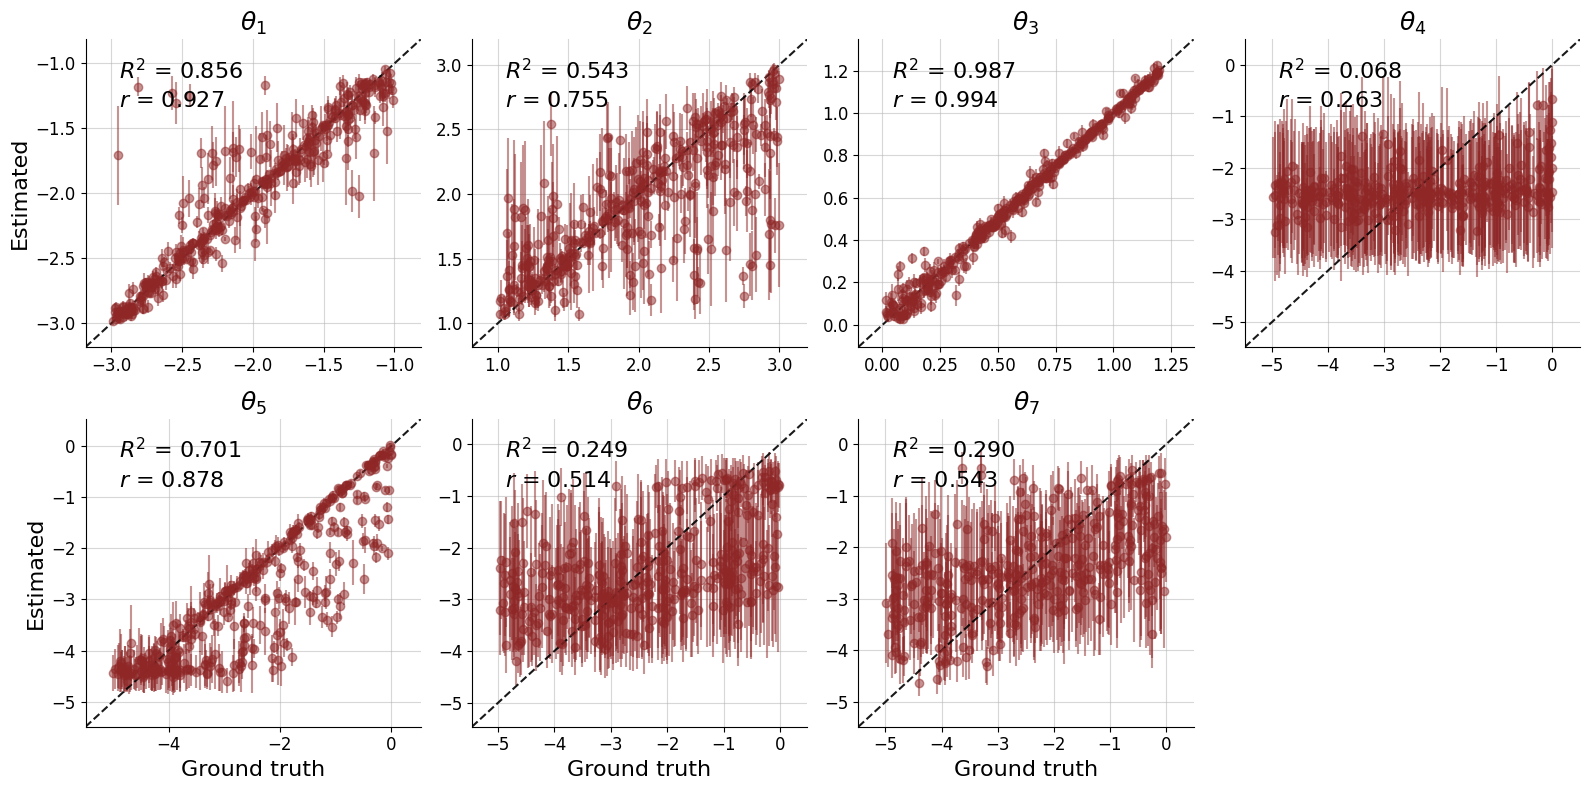

In [47]:
f = bf.diagnostics.plot_recovery(samples, conf['parameters'])

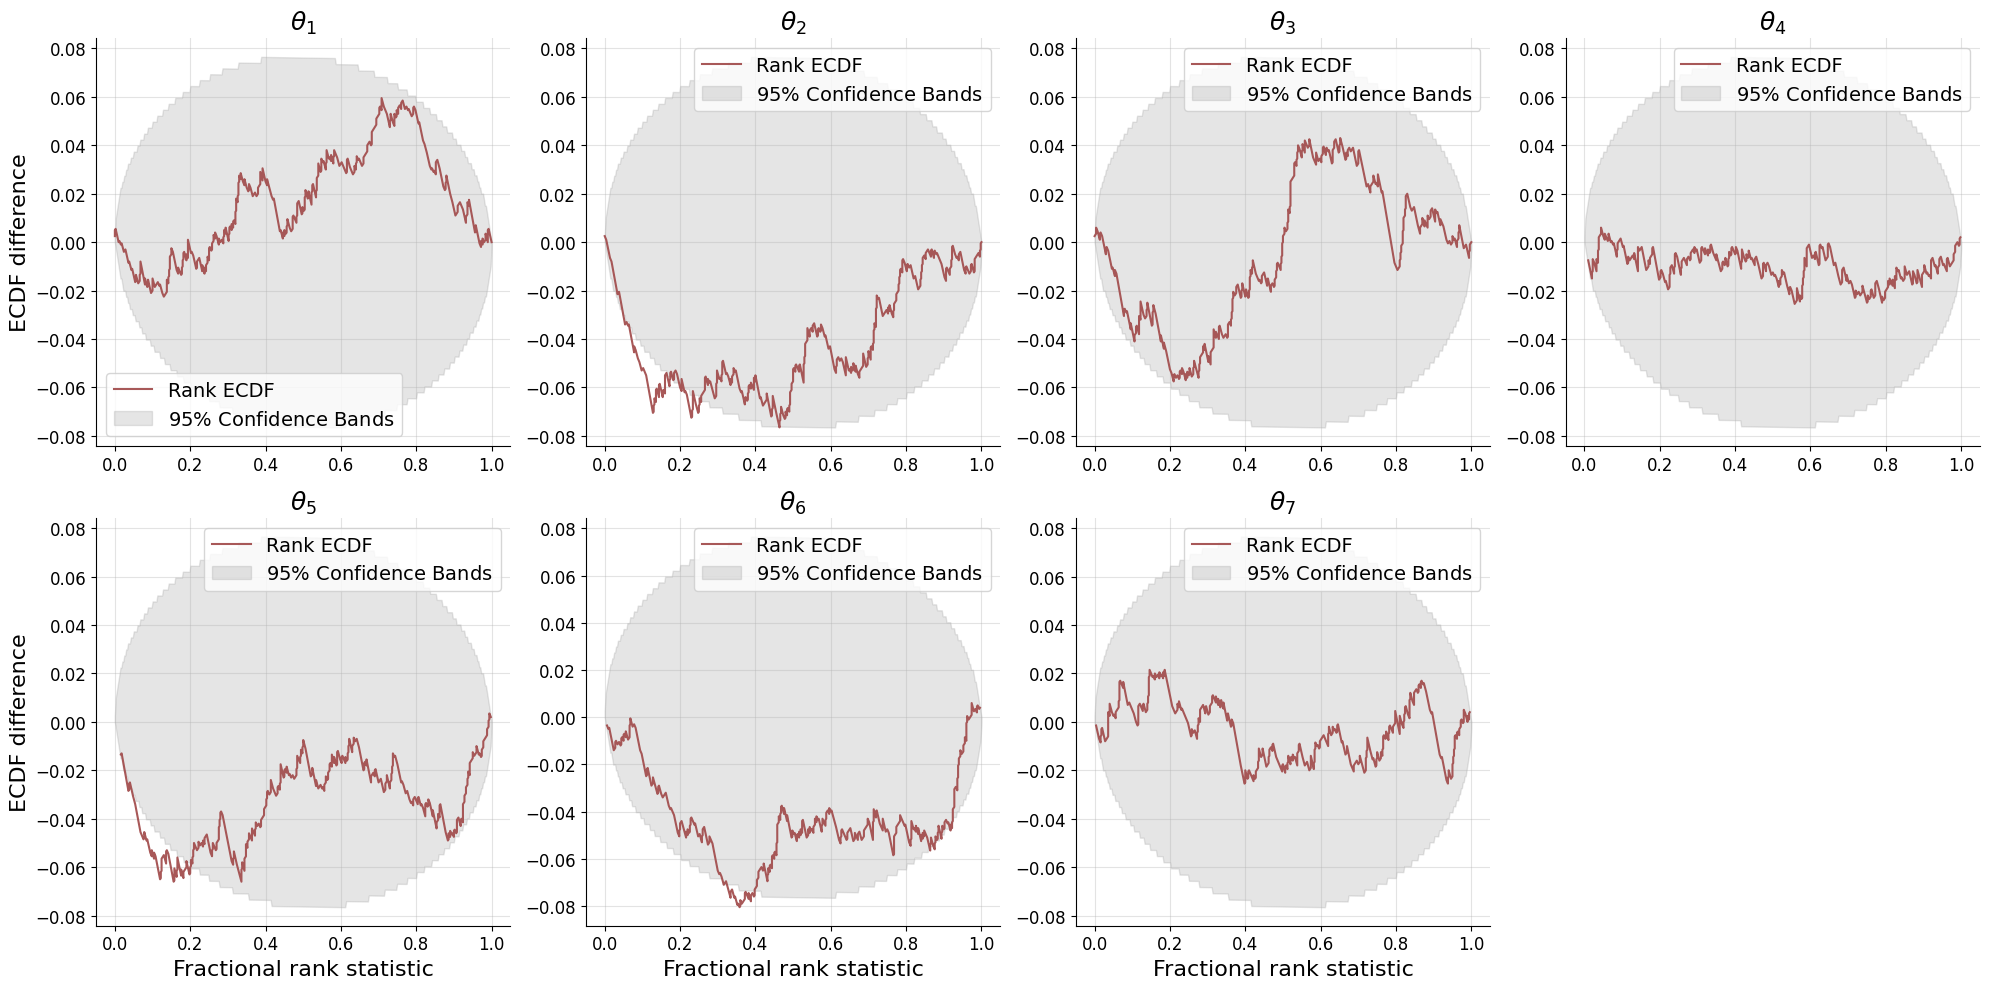

In [20]:
f = bf.diagnostics.plot_sbc_ecdf(samples, conf['parameters'], difference=True)